# Traffic Sign Image Recognition
## Convolutional Neural Network

### Table of Contents
- [Introduction](#introduction)
- [Model Architecture](#model-architecture)
- [Fit and Evaluate](#fit-and-evaluate)
  - [Base Model](#base-model)
  - [Weighted Base Model](#weighted-base-model)
  - [Two Convolutional Layers](#two-convolution-layers)
  - [Base Model with Batch Normalization](#base-model-with-batch-normalization)
  - [Two Convolutional Layers with Batch Normalization](#two-convolutional-layers-with-batch-normalization)
  - [Two Convolutional and Dense Layers](#two-convolutional-and-dense-layers)
  - [Two Convolutional and Dense Layers with Batch Normalization](#two-convolutional-and-dense-layers-with-batch-normalization)
- [Model Progression](#model-progression)
- [Final Model Evaluation](#final-model-evaluation)
- [Final Results](#final-results)

## Introduction

### Data Source: [German Traffic Sign Recognition Benchmark (GTSRB) dataset](https://benchmark.ini.rub.de/gtsrb_news.html)

The German Traffic Sign Recognition Benchmark (GTSRB) is a widely used dataset for traffic sign classification, containing over 50,000 labeled images spanning 43 classes. Each image captures a traffic sign in real-world conditions, with variations in lighting, perspective, and occlusion. Accurate recognition of these signs is critical for autonomous driving and driver-assistance systems.

In this project, the challenge is to design a series of neural network models capable of classifying traffic signs in the GTSRB dataset. The goal is to explore how architectural choices, regularization techniques, and class balancing strategies affect model performance, ultimately identifying a configuration that maximizes accuracy and generalization.

In [1]:
# Import dependencies
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from collections import Counter
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Ensure reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
# Global constants
# EPOCHS = 10
IMG_WIDTH = 30
IMG_HEIGHT = 30
NUM_CATEGORIES = 43
# TEST_SIZE = 0.4

# Load sign names as a dictionary: {class_id: sign_name}
signnames_df = pd.read_csv("signnames.csv")
SIGNNAME_MAP = dict(zip(signnames_df["ClassId"], signnames_df["SignName"]))

In [3]:
# Function to load data from directory
def load_data(data_dir):
    """
    Load image data from directory `data_dir`.

    Assume `data_dir` has one directory named after each category, numbered
    0 through NUM_CATEGORIES - 1. Inside each category directory will be some
    number of image files.

    Return tuple `(images, labels)`. `images` should be a list of all
    of the images in the data directory, where each image is formatted as a
    numpy ndarray with dimensions IMG_WIDTH x IMG_HEIGHT x 3. `labels` should
    be a list of integer labels, representing the categories for each of the
    corresponding `images`.
    """
    # Initialize lists to hold images and labels
    images = []
    labels = []

    # Process each image and append image and label to lists
    # Walk through the directory tree
    for dirpath, dirnames, filenames in os.walk(data_dir):
        for filename in filenames:
            # Construct full file path
            image_path = os.path.join(dirpath, filename)
            # Read and resize the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
            # Normalize pixel values to the range [0, 1] by dividing by 255.0
            # And converts from an integer type to a float type
            image = image / 255.0
            # Append image and label to lists
            images.append(image)
            # Extract label from directory name
            labels.append(int(os.path.basename(dirpath)))

    # Return the tuple of images and labels
    return (images, labels)

In [4]:
# Evaluation functions

# These functions will generate and save the following:
# Training/validation loss and accuracy curves
# Confusion matrix plot
# Classification report
# Show misclassified images
# Most common misclassifications
# Misclassification confidence histogram
# Model summary


# Training Curve
def plot_and_save_training_curves(history, model_name="model"):
    """
    Plot and save training curves for loss and accuracy.
    history: Keras History object from model training
    model_name: string, name to use in saved filenames
    """
    plt.figure(figsize=(12, 5))
    plt.suptitle(
        f"Training and Validation Curves ({model_name.replace('_', ' ')})", fontsize=16
    )

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Tight layout and save
    plt.tight_layout()
    plt.savefig(f"results/images/{model_name}_training_curves.png")
    plt.show()


# Confusion Matrix
def plot_and_save_confusion_matrix(y_true, y_pred_classes, model_name="model"):
    """
    Plot and save confusion matrix.
    y_true: true labels (1D array, int)
    y_pred_classes: predicted class indices (1D array, int)
    model_name: string, name to use in saved filenames
    """
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.title(f"Confusion Matrix\n({model_name.replace('_', ' ')})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Save the figure
    plt.savefig(f"results/images/{model_name}_confusion_matrix.png")
    plt.show()


# Classification Report
def save_classification_report(y_true, y_pred_classes, model_name="model"):
    """
    Generate and save classification report as CSV.
    y_true: true labels (1D array, int)
    y_pred_classes: predicted class indices (1D array, int)
    model_name: string, name to use in saved filenames
    """
    # Classification Report, convert to DataFrame and save as CSV
    report = classification_report(y_true, y_pred_classes, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(f"results/{model_name}_classification_report.csv")

    # Print the report to console
    print("Classification Report:")
    print(report_df)


# Show Misclassified Images
def show_top_misclassifications(
    x,
    y_true,
    y_pred,
    y_prob,
    signname_map=None,
    top_n=4,
    per_class=4,
    model_name="model",
):
    """
    Display and save top misclassified images.
    x: images (4D array, shape [n_samples, IMG_WIDTH, IMG_HEIGHT, 3])
    y_true: true labels (1D array, int)
    y_pred: predicted class indices (1D array, int)
    y_prob: softmax probabilities (2D array, shape [n_samples, n_classes])
    signname_map: dict mapping class_id to sign name (optional, defaults to SIGNNAME_MAP)
    top_n: number of top misclassification types to show
    per_class: number of images to show per misclassification type
    model_name: string, name to use in saved filenames
    """
    # Use default signname map if none provided
    if signname_map is None:
        signname_map = SIGNNAME_MAP

    # Find misclassifications, count occurrences, and get top N errors
    errors = [(t, p) for t, p in zip(y_true, y_pred) if t != p]
    counter = Counter(errors)
    top_errors = counter.most_common(top_n)
    images_to_show = []
    labels_to_show = []
    confidences = []

    # Collect images, labels, and confidences for top misclassifications
    for (true, pred), _ in top_errors:
        # Find indices of misclassifications
        idxs = np.where((y_true == true) & (y_pred == pred))[0]
        # Randomly shuffle and select up to `per_class` images
        if len(idxs) > per_class:
            idxs = np.random.choice(idxs, per_class, replace=False)
        # Append images, labels, and confidences
        for idx in idxs:
            images_to_show.append(x[idx])
            labels_to_show.append((true, pred))
            confidences.append(y_prob[idx, pred])

    # Plot the images
    n = len(images_to_show)
    plt.figure(figsize=(12, 12))
    plt.suptitle(
        f"Sample of Top {top_n} Most Common Misclassifications\n"
        f"({model_name.replace('_', ' ')})\n"
        "Each image shows: True label, Predicted label, and Model Confidence",
        fontsize=16,
    )
    for i in range(n):
        plt.subplot(top_n, per_class, i + 1)
        plt.imshow(images_to_show[i])
        true_label, pred_label = labels_to_show[i]
        conf = confidences[i]
        true_name = signname_map.get(true_label, str(true_label))
        pred_name = signname_map.get(pred_label, str(pred_label))
        plt.title(f"T:{true_name}\nP:{pred_name}\nConfidence:{conf:.2f}")
        plt.axis("off")

    # Tight layout and save
    plt.tight_layout()
    plt.savefig(f"results/images/{model_name}_top_misclassifications.png")
    plt.show()


# Most Common Misclassifications
def most_common_misclassifications(y_true, y_pred, top_n=5, signname_map=SIGNNAME_MAP):
    """
    Print the most common misclassifications.
    y_true: true labels (1D array, int)
    y_pred: predicted class indices (1D array, int)
    top_n: number of top misclassification types to show
    signname_map: dictionary mapping class ids to sign names
    """
    # Find misclassifications, count occurrences, and print top N errors
    errors = [(t, p) for t, p in zip(y_true, y_pred) if t != p]
    counter = Counter(errors)
    print(f"Total Misclassifications: {len(errors)}")
    print(f"Top {top_n} Most Common Misclassifications:")
    for (true, pred), count in counter.most_common(top_n):
        true_name = signname_map.get(true, str(true))
        pred_name = signname_map.get(pred, str(pred))
        print(
            f"* {true_name} (label {true}) predicted as {pred_name} (label {pred}) — {count} times"
        )


# Misclassification Confidence Histogram
def plot_misclassification_confidence_histogram(
    y_true, y_pred_classes, y_prob, bins=10, model_name="model"
):
    """
    Plot and save a histogram of model confidence (predicted probability) for misclassified samples.
    y_true: true labels (1D array, int)
    y_pred_classes: predicted class indices (1D array, int)
    y_prob: softmax probabilities (2D array, shape [n_samples, n_classes])
    bins: number of bins in the histogram
    model_name: string, name to use in saved filenames
    """
    # Find indices of misclassified samples
    misclassified = np.where(y_true != y_pred_classes)[0]
    # If no misclassifications, print message and return
    if len(misclassified) == 0:
        print("No misclassifications to plot.")
        return

    # Get predicted probabilities (confidences) for the predicted classes of misclassified samples
    confidences = y_prob[misclassified, y_pred_classes[misclassified]]

    # Plot histogram
    plt.figure(figsize=(8, 4))
    plt.hist(confidences, bins=bins, color="tomato", edgecolor="black")
    plt.title(
        f"Model Confidence in Misclassifications\n"
        f"({model_name.replace('_', ' ')})\n"
        f"{len(misclassified)} errors of {len(y_true)} samples"
    )
    plt.xlabel("Predicted Probability (Confidence)")
    plt.ylabel("Number of Misclassified Samples")

    # Save the figure
    plt.tight_layout()
    plt.savefig(
        f"results/images/{model_name}_misclassification_confidence_histogram.png"
    )
    plt.show()


# Model Summary
def save_model_summary(model, model_name="model"):
    """
    Save model summary to a text file.
    model: Keras model
    model_name: string, name to use in saved filename
    """
    with open(f"results/{model_name}_summary.txt", "w") as f:
        model.summary(print_fn=lambda x: f.write(x + "\n"))
    print("Model summary saved.")

## Model Architecture

[Back to Top](#)

The models are built sequentially, starting from a simple baseline and gradually adding complexity. Key modifications include:

- Class weighting to mitigate imbalance.
- Additional convolutional layers for richer feature extraction.
- Batch normalization to stabilize training and improve calibration.
- Additional dense layers (explored but found to reduce performance).

The seven models implemented are:
- Base Model
- Base Model + Class Weights
- Base Model + Second Conv Layer
- Base Model + Batch Normalization
- Base Model + Second Conv Layer + Batch Normalization (best performing model)
- Base Model + Second Conv Layer + Dense Layer
- Base Model + Second Conv Layer + Dense Layer + Batch Normalization

In [5]:
# Base Model, inspired by MNIST example
# Run twice, the second time with class weights, to help with imbalanced classes
def Base_Model():
    """
    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    # Create a Sequential model (starting with MNIST example)
    model = tf.keras.Sequential(
        [
            # Convolution detects the signal from the noise in images
            # by applying filters and amplifying the important features
            # ---
            # Convolutional layer (2D) with 32 filters, 3x3 kernel, ReLU activation
            # 32 filters: pattern detectors (edges, colors, shapes, etc.)
            # Kernel: Slides over 3x3 pixel regions, computing a weighted sum to highlight features
            # ReLU: Zeros negative values on filters, so triggered filters can add up
            # instead of canceling each other out
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
            ),
            # Max-pooling keeps the strongest features while reducing the data size
            # 2x2 pool size: takes the maximum of each 2x2 block of pixels
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Flattening turns the square image into a single long line of neurons
            tf.keras.layers.Flatten(),
            # Dense layer, fully connected, all 128 of them
            # Every neuron weighs every incoming flattened neuron
            tf.keras.layers.Dense(128, activation="relu"),
            # Dropout randomly turns off neurons to prevent overfitting
            # Applied only to the immediately preceding (Dense) layer
            tf.keras.layers.Dropout(0.5),
            # Output layer: one neuron per category
            # Softmax: converts outputs into probabilities summing to 1
            # The category with the highest probability is the model's prediction
            tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax"),
        ]
    )

    # Compile the model
    model.compile(
        # Adam: adaptive optimizer that adjusts the learning rate throughout training
        optimizer="adam",
        # categorical_crossentropy: penalizes the model when it gives low probability to the correct class
        # e.g., if a cat image is predicted as 60% cat, 20% dog, 10% rabbit, 10% llama, the loss will be high
        loss="categorical_crossentropy",
        # Metric for evaluation: simple accuracy (fraction of correct predictions)
        metrics=["accuracy"],
    )

    return model

In [6]:
# Model with two convolutional layers
# The first layer finds simple features like edges and colors
# The second layer combines those features to find more complex patterns
# Like corners, shapes, or sign symbols
def Two_Convolutional_Layers():
    """
    Add a second convolutional layer to the Base Model.

    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    # Create a Sequential model
    model = tf.keras.Sequential(
        [
            # Convolutional layer. Learn 32 filters using a 3x3 kernel
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
            ),
            # Max-pooling layer, using 2x2 pool size
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Second Convolutional layer. Learn 64 filters using a 3x3 kernel
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Flatten units
            tf.keras.layers.Flatten(),
            # Add a hidden layer with dropout
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            # # Add an output layer with output units for all categories
            tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax"),
        ]
    )

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [7]:
# Base Model with Batch Normalization
# Normalizes the outputs of a previous layer to have similar distributions (0 mean, 1 stddev)
# Puts all outputs on a level playing field
# Speeds up training, reduces risk of overfitting, allows use of higher learning rates
def Base_w_Batch_Normalization():
    """
    Add Batch Normalization to the Base Model.

    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    # Create a Sequential model
    model = tf.keras.Sequential(
        [
            # Convolutional layer. Learn 32 filters using a 3x3 kernel
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
            ),
            # Batch Normalization layer
            tf.keras.layers.BatchNormalization(),
            # Max-pooling layer, using 2x2 pool size
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Flatten units
            tf.keras.layers.Flatten(),
            # Add a hidden layer with dropout
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            # # Add an output layer with output units for all categories
            tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax"),
        ]
    )

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [8]:
# Two Convolutional layers with Batch Normalization
# Hoping to get the benefits of both
def Two_Convolutional_w_Batch_Normalization():
    """
    Add a second convolutional layer and Batch Normalization to the Base Model.

    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    # Create a Sequential model
    model = tf.keras.Sequential(
        [
            # Convolutional layer. Learn 32 filters using a 3x3 kernel
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
            ),
            # Batch Normalization layer
            tf.keras.layers.BatchNormalization(),
            # Max-pooling layer, using 2x2 pool size
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Second Convolutional layer. Learn 64 filters using a 3x3 kernel
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Flatten units
            tf.keras.layers.Flatten(),
            # Add a hidden layer with dropout
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            # # Add an output layer with output units for all categories
            tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax"),
        ]
    )

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [9]:
# Two Convolutional and two Dense layers
# A second Dense layer to learn more complex combinations of features
# Potentially better performance, but also more prone to overfitting
# It's an experiment! For Science!
def Two_Convolutional_w_Two_Dense():
    """
    Adds a second convolutional layer and a second Dense layer to the base model.

    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    # Create a Sequential model (starting with MNIST example)
    model = tf.keras.Sequential(
        [
            # Convolutional layer. Learn 32 filters using a 3x3 kernel
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
            ),
            # Max-pooling layer, using 2x2 pool size
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Second convolutional layer (2D) with 64 filters, 3x3 kernel, ReLU activation
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Flatten units
            tf.keras.layers.Flatten(),
            # Add two hidden layers with dropout
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            # Add an output layer with output units for all categories
            tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax"),
        ]
    )

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [10]:
# Two Convolutional, two Dense layers with Batch Normalization
def Two_Convolutional_Two_Dense_Batch_Normalization():
    """
    Adds a second convolutional layer, a second Dense layer, and Batch Normalization to the base model.

    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    # Create a Sequential model (starting with MNIST example)
    model = tf.keras.Sequential(
        [
            # Convolutional layer. Learn 32 filters using a 3x3 kernel
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
            ),
            # Batch Normalization layer
            tf.keras.layers.BatchNormalization(),
            # Max-pooling layer, using 2x2 pool size
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Second convolutional layer (2D) with 64 filters, 3x3 kernel, ReLU activation
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Flatten units
            tf.keras.layers.Flatten(),
            # Add two hidden layers with dropout
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            # Add an output layer with output units for all categories
            tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax"),
        ]
    )

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

## Fit and Evaluate

[Back to Top](#)

Each model is trained on the GTSRB training set and evaluated on a validation/test split. Standard training procedures include categorical cross-entropy loss, Adam optimizer, and early stopping. Performance is assessed using accuracy, precision, recall, and f1-score at both the class and overall levels.

In [11]:
# Get image arrays and labels for all image files
images, labels = load_data("gtsrb")

# Split data into training and testing sets
labels = tf.keras.utils.to_categorical(labels)

# First split: train vs. temp (val+test)
x_train, x_temp, y_train, y_temp = train_test_split(
    np.array(images), np.array(labels), test_size=0.4, random_state=42
)
# Second split: val vs. test (split temp into val and test)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42
)


# Train and evaluate model function
def train_and_evaluate(
    model_fn,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    epochs=10,
    early_stopping=False,
    use_class_weight=False,
    model_name=None,
):
    # Extract model name from function if not provided
    if model_name is None:
        model_name = model_fn.__name__

    # Callbacks for training
    callbacks = []
    # Early stopping callback
    if early_stopping:
        callbacks.append(
            EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
        )
    # Learning rate reduction callback
    callbacks.append(
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
    )

    # Compute class weights if needed
    class_weight = None
    if use_class_weight:
        y_train_labels = y_train.argmax(axis=1)
        class_weight_values = compute_class_weight(
            class_weight="balanced", classes=np.unique(y_train_labels), y=y_train_labels
        )
        class_weight = dict(enumerate(class_weight_values))

    # Build and train the model, evaluate on validation set
    model = model_fn()
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        class_weight=class_weight,
    )
    model.evaluate(x_val, y_val, verbose=2)

    # Plot and save training/validation loss and accuracy curves
    plot_and_save_training_curves(history, model_name)

    # Predict on validation set
    y_pred = model.predict(x_val)
    y_pred_classes = y_pred.argmax(axis=1)
    y_true = y_val.argmax(axis=1)

    # Confusion matrix
    plot_and_save_confusion_matrix(y_true, y_pred_classes, model_name)

    # Classification report
    save_classification_report(y_true, y_pred_classes, model_name)

    # Show misclassified images
    show_top_misclassifications(
        x_val, y_true, y_pred_classes, y_pred, model_name=model_name
    )

    # Most common misclassifications
    most_common_misclassifications(y_true, y_pred_classes, top_n=5)

    # Misclassification confidence histogram
    plot_misclassification_confidence_histogram(
        y_true, y_pred_classes, y_pred, model_name=model_name
    )

    # Save model summary to text file
    save_model_summary(model, model_name)

    # Save history and the model
    pd.DataFrame(history.history).to_csv(
        f"results/{model_name}_history.csv", index=False
    )
    model.save(f"models/{model_name}.h5")
    print(f"Model saved to {model_name}.h5")

## Base Model
[Back to Top](#)

Epoch 1/10
500/500 [==============================] - 15s 26ms/step - loss: 2.3093 - accuracy: 0.3801 - val_loss: 1.1288 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 14s 29ms/step - loss: 1.1379 - accuracy: 0.6650 - val_loss: 0.5996 - val_accuracy: 0.8624 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 13s 26ms/step - loss: 0.8084 - accuracy: 0.7541 - val_loss: 0.4125 - val_accuracy: 0.9240 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 10s 19ms/step - loss: 0.6494 - accuracy: 0.8016 - val_loss: 0.2968 - val_accuracy: 0.9289 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 9s 19ms/step - loss: 0.5606 - accuracy: 0.8269 - val_loss: 0.2614 - val_accuracy: 0.9289 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - 10s 19ms/step - loss: 0.4873 - accuracy: 0.8529 - val_loss: 0.1973 - val_accuracy: 0.9559 - lr: 0.0010
Epoch 7/10
500/500 [==============================] - 8s 17

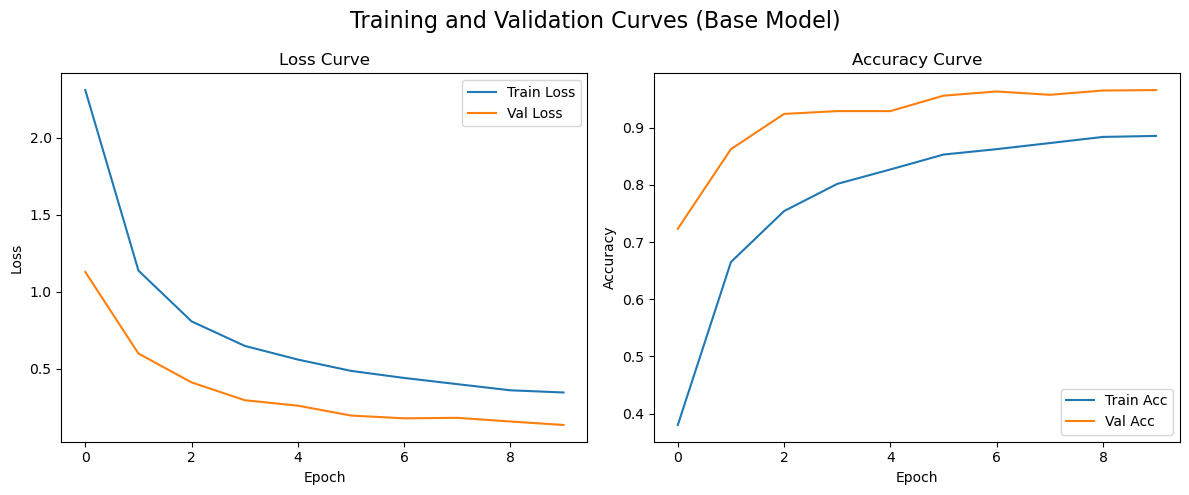

167/167 [==============================] - 1s 5ms/step


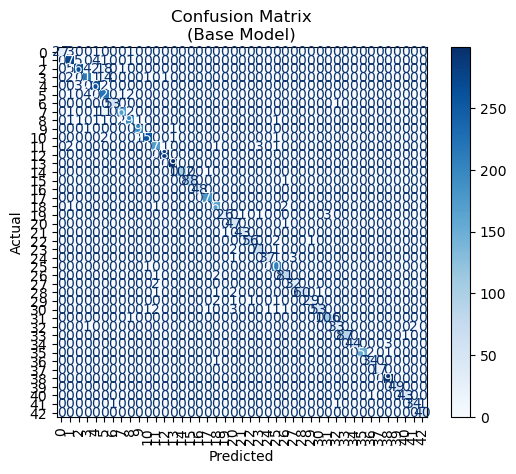

Classification Report:
              precision    recall  f1-score      support
0              1.000000  0.843750  0.915254    32.000000
1              0.945017  0.961538  0.953206   286.000000
2              0.967033  0.897959  0.931217   294.000000
3              0.955752  0.919149  0.937093   235.000000
4              0.963370  0.981343  0.972274   268.000000
5              0.817844  0.964912  0.885312   228.000000
6              0.981481  0.981481  0.981481    54.000000
7              0.976744  0.918033  0.946479   183.000000
8              0.965174  0.960396  0.962779   202.000000
9              0.989848  0.989848  0.989848   197.000000
10             0.988372  0.980769  0.984556   260.000000
11             0.960894  0.955556  0.958217   180.000000
12             0.993031  1.000000  0.996503   285.000000
13             0.993355  1.000000  0.996667   299.000000
14             1.000000  0.990291  0.995122   103.000000
15             1.000000  0.988764  0.994350    89.000000
16      

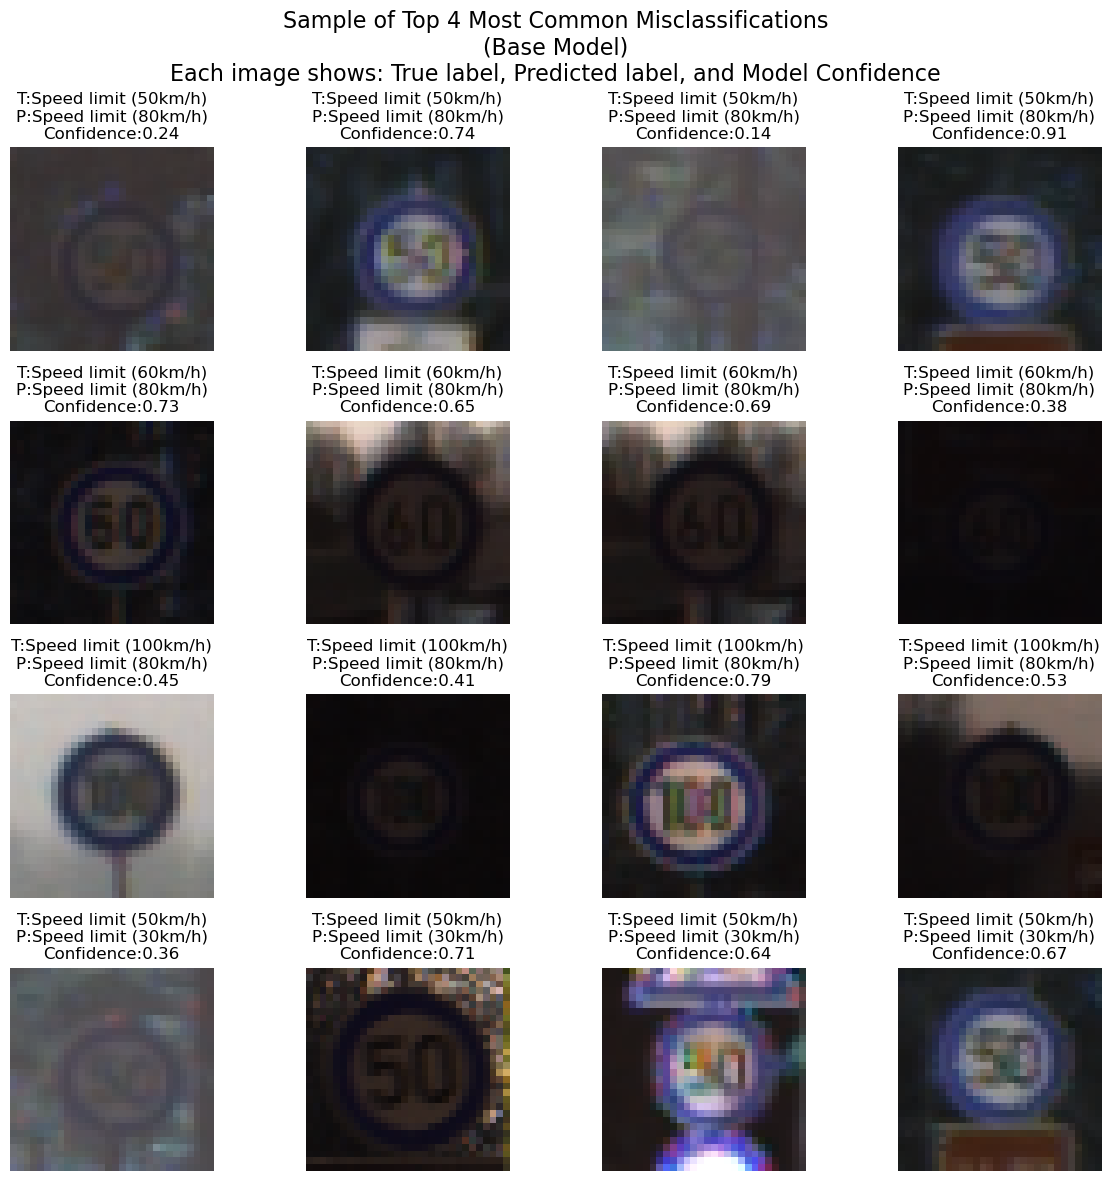

Total Misclassifications: 183
Top 5 Most Common Misclassifications:
* Speed limit (50km/h) (label 2) predicted as Speed limit (80km/h) (label 5) — 18 times
* Speed limit (60km/h) (label 3) predicted as Speed limit (80km/h) (label 5) — 14 times
* Speed limit (100km/h) (label 7) predicted as Speed limit (80km/h) (label 5) — 11 times
* Speed limit (50km/h) (label 2) predicted as Speed limit (30km/h) (label 1) — 5 times
* Speed limit (30km/h) (label 1) predicted as Speed limit (50km/h) (label 2) — 5 times


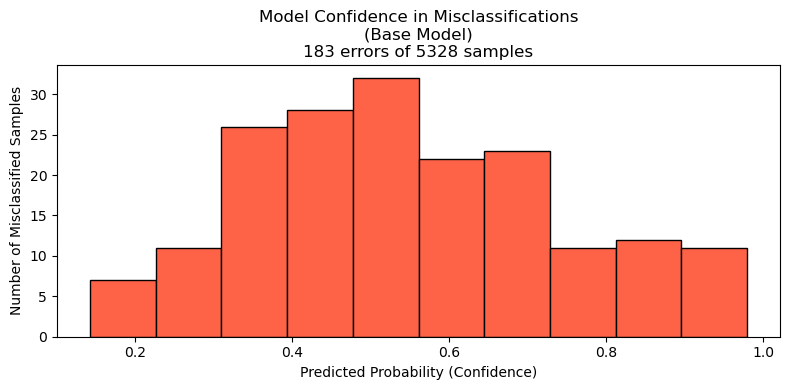

Model summary saved.
Model saved to Base_Model.h5


In [12]:
# Evaluate base model
train_and_evaluate(Base_Model)

### Results for Base Model

The Base Model provides a strong foundation, achieving 96.6% accuracy, with weighted precision, recall, and f1-scores all in the 0.96–0.97 range. While this marks a solid starting point, the results leave clear room for improvement compared to later architectures.

Performance is generally high across most classes, with many achieving precision and recall above 0.95, including several minority categories (e.g., classes 6, 16, 37, 39). However, some weaknesses are apparent. Class 5, representing speed limit signs, is especially problematic: precision falls to 0.82, the lowest among major classes, as the model produces many false positives when confusing visually similar signs (speed limit signs with different numeric values). Other mid-sized classes also show inconsistency, such as class 20 (precision 0.84) and class 30 (recall 0.84). Minority classes are hit-or-miss: some achieve perfect scores, while others (e.g., class 19 with recall 0.84, class 29 with recall 0.85) lag behind.

Training and validation curves show a small gap, likely due to dropout being active during training rather than genuine overfitting. The confidence histogram appears well-calibrated, with predictions spread smoothly across probability bins rather than clustering too sharply at the extremes.

In short, the Base Model demonstrates robust performance but struggles with class imbalance and visually similar categories. These results highlight the need for architectural refinements—such as additional convolutional layers or batch normalization—to boost generalization and reduce systematic errors.

## Weighted Base Model
[Back to Top](#)

Epoch 1/20
500/500 [==============================] - 10s 19ms/step - loss: 2.7221 - accuracy: 0.2679 - val_loss: 1.3882 - val_accuracy: 0.7239 - lr: 0.0010
Epoch 2/20
500/500 [==============================] - 9s 17ms/step - loss: 1.3774 - accuracy: 0.5569 - val_loss: 0.8045 - val_accuracy: 0.8489 - lr: 0.0010
Epoch 3/20
500/500 [==============================] - 9s 18ms/step - loss: 0.9537 - accuracy: 0.6667 - val_loss: 0.5539 - val_accuracy: 0.8855 - lr: 0.0010
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.7588 - accuracy: 0.7285 - val_loss: 0.4609 - val_accuracy: 0.8861 - lr: 0.0010
Epoch 5/20
500/500 [==============================] - 9s 18ms/step - loss: 0.6389 - accuracy: 0.7614 - val_loss: 0.3492 - val_accuracy: 0.9123 - lr: 0.0010
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.5632 - accuracy: 0.7836 - val_loss: 0.2900 - val_accuracy: 0.9281 - lr: 0.0010
Epoch 7/20
500/500 [==============================] - 9s 18ms/s

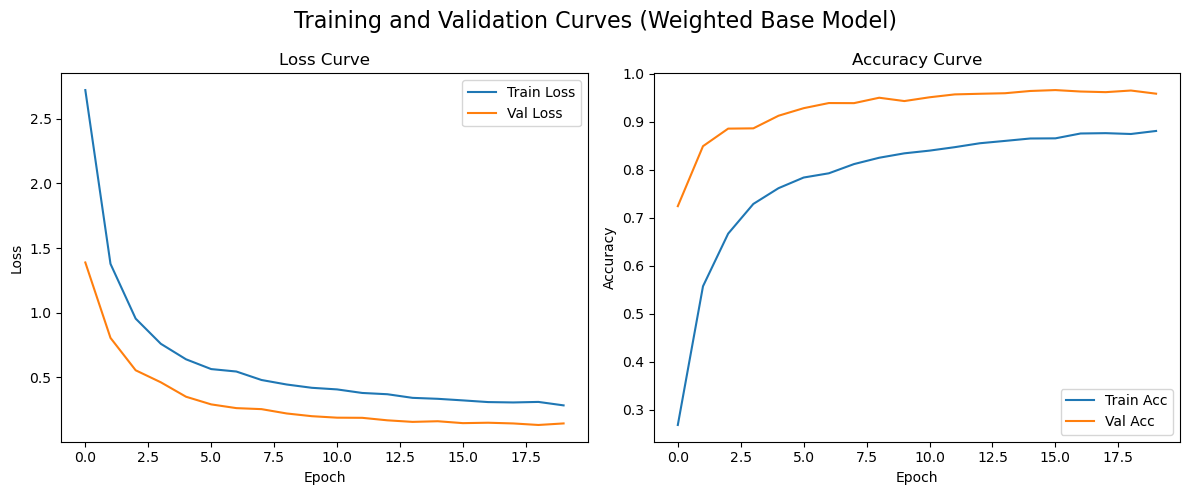

167/167 [==============================] - 1s 5ms/step


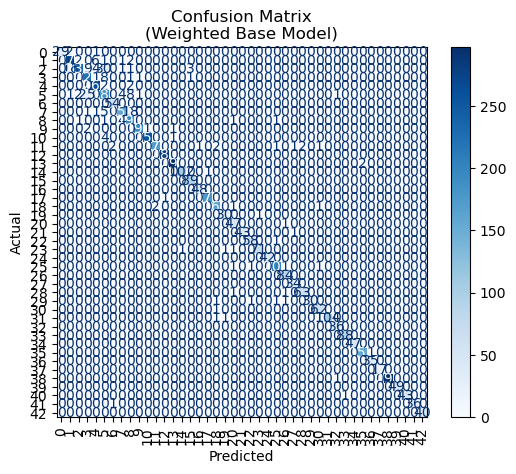

Classification Report:
              precision    recall  f1-score      support
0              1.000000  0.906250  0.950820    32.000000
1              0.935154  0.958042  0.946459   286.000000
2              0.978723  0.782313  0.869565   294.000000
3              0.857692  0.948936  0.901010   235.000000
4              0.953069  0.985075  0.968807   268.000000
5              0.784810  0.815789  0.800000   228.000000
6              0.947368  1.000000  0.972973    54.000000
7              0.940476  0.863388  0.900285   183.000000
8              0.858407  0.960396  0.906542   202.000000
9              0.989744  0.979695  0.984694   197.000000
10             0.996094  0.980769  0.988372   260.000000
11             0.988372  0.944444  0.965909   180.000000
12             0.996503  1.000000  0.998249   285.000000
13             0.993311  0.993311  0.993311   299.000000
14             0.990291  0.990291  0.990291   103.000000
15             0.956989  1.000000  0.978022    89.000000
16      

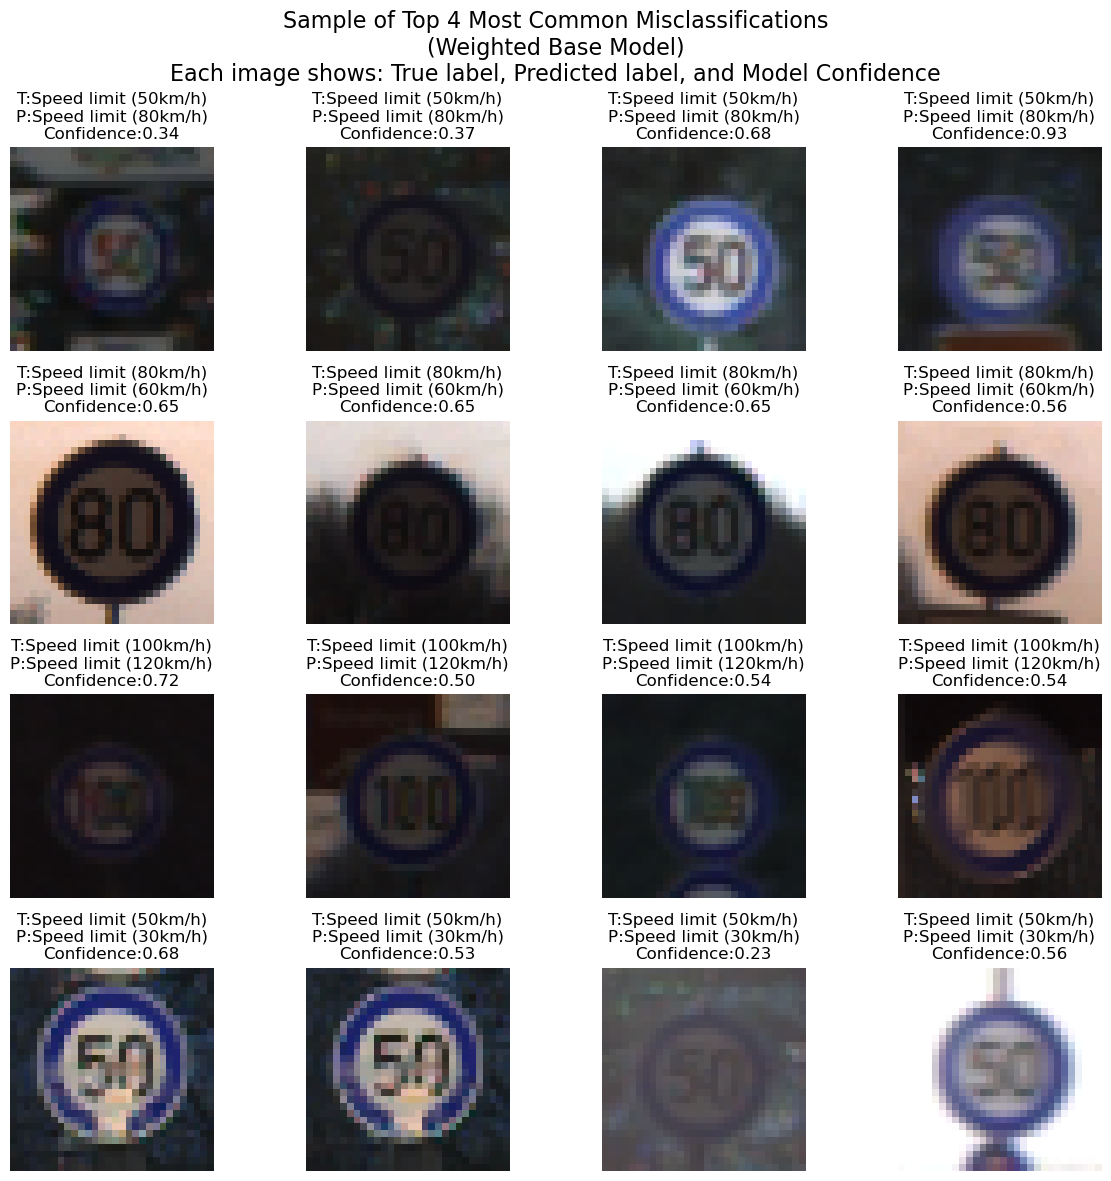

Total Misclassifications: 222
Top 5 Most Common Misclassifications:
* Speed limit (50km/h) (label 2) predicted as Speed limit (80km/h) (label 5) — 30 times
* Speed limit (80km/h) (label 5) predicted as Speed limit (60km/h) (label 3) — 25 times
* Speed limit (100km/h) (label 7) predicted as Speed limit (120km/h) (label 8) — 18 times
* Speed limit (50km/h) (label 2) predicted as Speed limit (30km/h) (label 1) — 16 times
* Speed limit (50km/h) (label 2) predicted as Speed limit (60km/h) (label 3) — 9 times


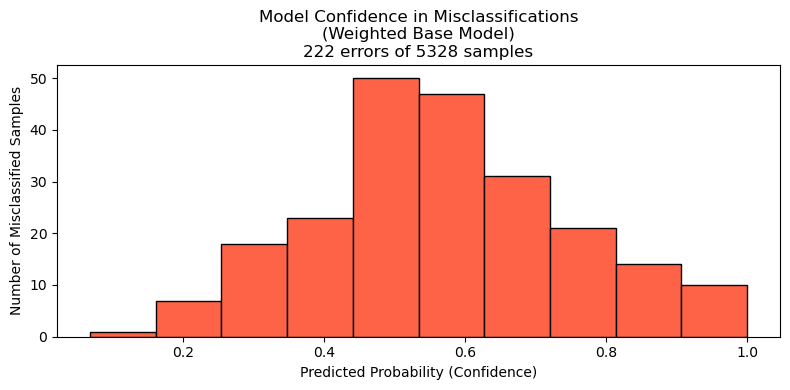

Model summary saved.
Model saved to Weighted_Base_Model.h5


In [13]:
# Evaluate base model with early stopping, class weights, and 20 epochs
train_and_evaluate(
    Base_Model,
    epochs=20,
    early_stopping=True,
    use_class_weight=True,
    model_name="Weighted_Base_Model",
)

### Results for Weight Base Model (with early stopping and 20 epochs)

The weighted Base Model reaches 95.8% overall accuracy, with weighted precision, recall, and f1-score all close to 0.96. This is slightly lower than the unweighted Base Model, but still demonstrates strong performance.

Applying class weights appears to have shifted trade-offs between precision and recall. In the majority, for example, class 2 shows noticeably lower recall (0.78) despite very high precision (0.98), while classes such as 3 and 8 achieve higher recall (~0.95) at the cost of precision (0.86). Several minority classes (e.g., 24, 27, 32, 34, 36, 42) now achieve perfect or near-perfect scores, suggesting that weighting helped the model attend more to underrepresented categories.

Class 5 continues to be problematic, with both lower precision (0.82 to 0.78) and recall (0.96 to 0.82) compared to the Base Model, indicating that speed limit signs remain a source of confusion even with weighting.

The overall calibration of predictions remains balanced, with no clear evidence of systematic overconfidence or underconfidence.

In short, class weighting improved performance on many minority classes but slightly reduced overall accuracy and consistency, highlighting the trade-off between global performance and minority class support.

## Two Convolutional Layers
[Back to Top](#)

Epoch 1/10
500/500 [==============================] - 12s 23ms/step - loss: 2.4057 - accuracy: 0.3431 - val_loss: 1.0886 - val_accuracy: 0.6757 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 10s 21ms/step - loss: 1.0046 - accuracy: 0.6869 - val_loss: 0.4289 - val_accuracy: 0.8823 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 11s 21ms/step - loss: 0.6018 - accuracy: 0.8133 - val_loss: 0.2633 - val_accuracy: 0.9351 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 10s 20ms/step - loss: 0.4343 - accuracy: 0.8639 - val_loss: 0.1792 - val_accuracy: 0.9628 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 10s 21ms/step - loss: 0.3496 - accuracy: 0.8873 - val_loss: 0.1250 - val_accuracy: 0.9718 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - 10s 20ms/step - loss: 0.2820 - accuracy: 0.9107 - val_loss: 0.0982 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 7/10
500/500 [==============================] - 10s 

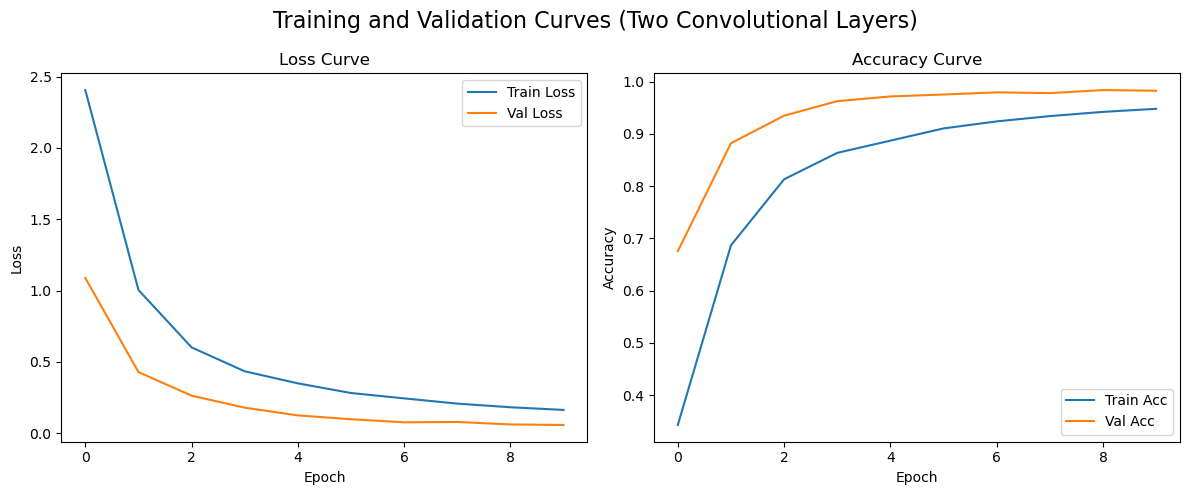

167/167 [==============================] - 1s 8ms/step


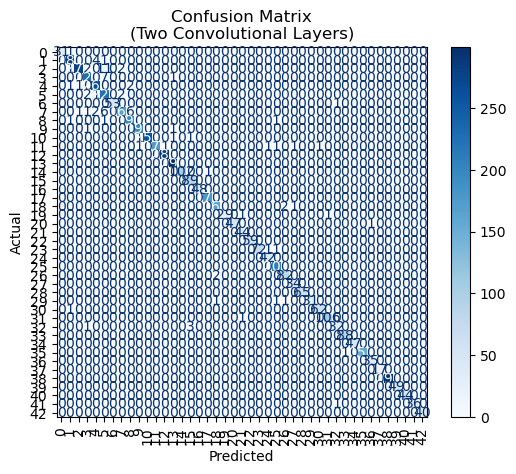

Classification Report:
              precision    recall  f1-score      support
0              1.000000  0.968750  0.984127    32.000000
1              0.982517  0.982517  0.982517   286.000000
2              0.992857  0.945578  0.968641   294.000000
3              0.970085  0.965957  0.968017   235.000000
4              0.974170  0.985075  0.979592   268.000000
5              0.895582  0.978070  0.935010   228.000000
6              1.000000  0.981481  0.990654    54.000000
7              0.976608  0.912568  0.943503   183.000000
8              0.961353  0.985149  0.973105   202.000000
9              0.989848  0.989848  0.989848   197.000000
10             1.000000  0.988462  0.994197   260.000000
11             1.000000  0.966667  0.983051   180.000000
12             0.996503  1.000000  0.998249   285.000000
13             0.990066  1.000000  0.995008   299.000000
14             1.000000  0.990291  0.995122   103.000000
15             0.956989  1.000000  0.978022    89.000000
16      

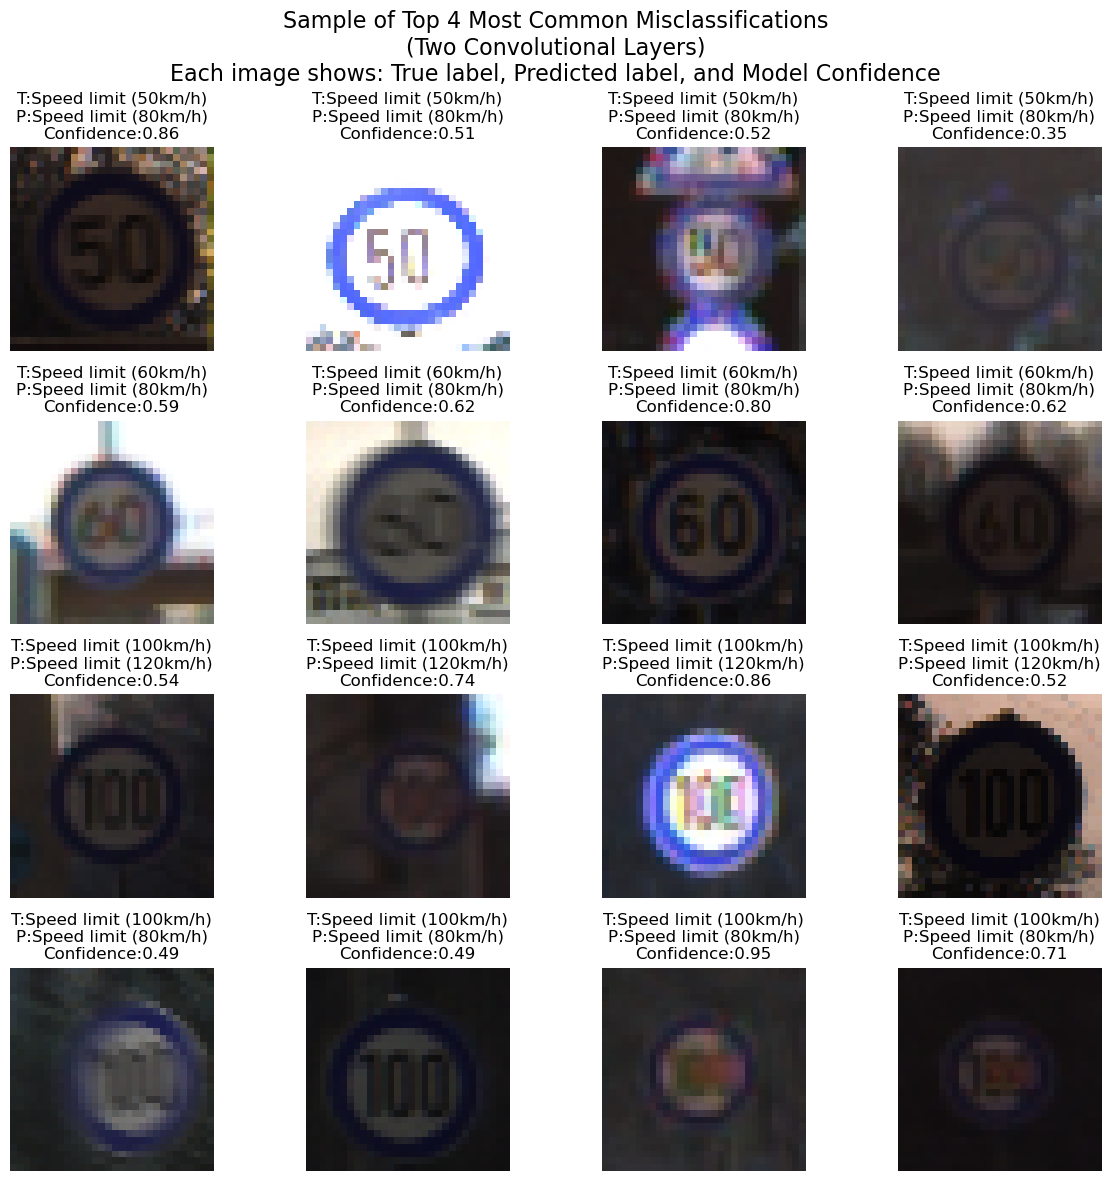

Total Misclassifications: 92
Top 5 Most Common Misclassifications:
* Speed limit (50km/h) (label 2) predicted as Speed limit (80km/h) (label 5) — 11 times
* Speed limit (60km/h) (label 3) predicted as Speed limit (80km/h) (label 5) — 7 times
* Speed limit (100km/h) (label 7) predicted as Speed limit (120km/h) (label 8) — 6 times
* Speed limit (100km/h) (label 7) predicted as Speed limit (80km/h) (label 5) — 6 times
* Speed limit (30km/h) (label 1) predicted as Speed limit (70km/h) (label 4) — 4 times


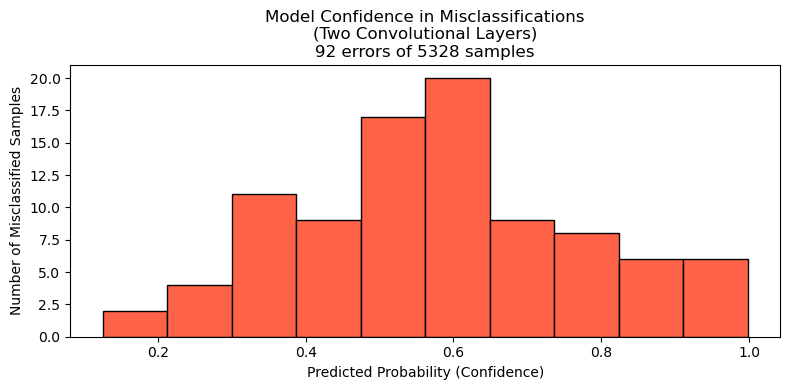

Model summary saved.
Model saved to Two_Convolutional_Layers.h5


In [14]:
# Evaluate two Convolutional layer model
train_and_evaluate(Two_Convolutional_Layers)

### Results for Base Model with Second Convolutional Layer

Adding a second convolutional layer significantly improves performance, with overall accuracy rising to 98.3% (vs. 96.6% for the Base Model and 95.8% with class weights). Weighted precision, recall, and f1-score all hover around 0.98, marking a clear step up in generalization.

This model shows strong improvements in previously weaker classes. For example, class 5 (a common source of confusion among similar speed limit signs) improves from precision 0.82 (Base) and 0.78 (Weighted) to 0.90, with recall climbing as high as 0.98. Other historically tricky categories like classes 19, 20, 24, 29, and 30 also report near-perfect metrics, often achieving both precision and recall above 0.95.

Nearly all minority classes reach perfect scores (precision, recall, f1 = 1.00), suggesting the deeper convolutional structure better captures subtle features even with limited data. Only a few small classes (e.g., 32 with f1 = 0.91) still lag slightly.

In short, the additional convolutional layer boosts feature extraction capacity, leading to higher accuracy, stronger minority class performance, and more consistent predictions across the full label set. This architecture outperforms both the Base and Weighted Base Models without signs of overfitting.

## Base Model with Batch Normalization
[Back to Top](#)

Epoch 1/10
500/500 [==============================] - 12s 24ms/step - loss: 1.3621 - accuracy: 0.6306 - val_loss: 0.5439 - val_accuracy: 0.9039 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 12s 25ms/step - loss: 0.4245 - accuracy: 0.8716 - val_loss: 0.1650 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 12s 23ms/step - loss: 0.2974 - accuracy: 0.9117 - val_loss: 0.1528 - val_accuracy: 0.9621 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 12s 25ms/step - loss: 0.2276 - accuracy: 0.9304 - val_loss: 0.1323 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 14s 28ms/step - loss: 0.1922 - accuracy: 0.9411 - val_loss: 0.0990 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - 12s 23ms/step - loss: 0.1779 - accuracy: 0.9460 - val_loss: 0.1038 - val_accuracy: 0.9711 - lr: 0.0010
Epoch 7/10
500/500 [==============================] - 11s 

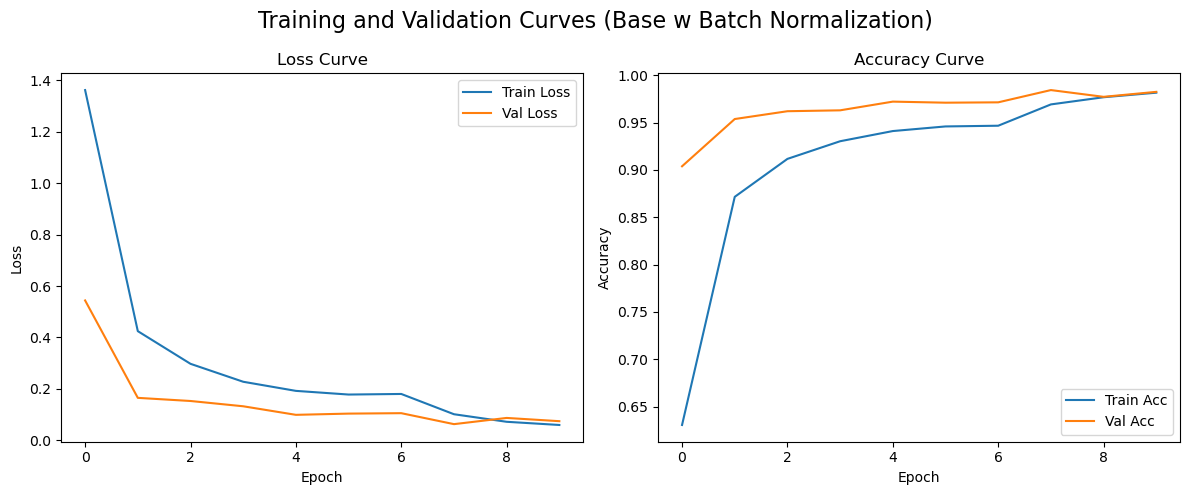

167/167 [==============================] - 1s 6ms/step


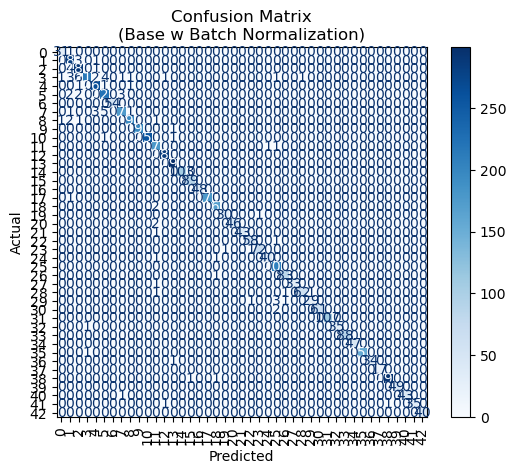

Classification Report:
              precision    recall  f1-score      support
0              0.939394  0.968750  0.953846    32.000000
1              0.952703  0.986014  0.969072   286.000000
2              0.956954  0.982993  0.969799   294.000000
3              0.990741  0.910638  0.949002   235.000000
4              0.974265  0.988806  0.981481   268.000000
5              0.952586  0.969298  0.960870   228.000000
6              1.000000  1.000000  1.000000    54.000000
7              0.971910  0.945355  0.958449   183.000000
8              0.985000  0.975248  0.980100   202.000000
9              1.000000  0.994924  0.997455   197.000000
10             1.000000  0.992308  0.996139   260.000000
11             0.951872  0.988889  0.970027   180.000000
12             0.993031  1.000000  0.996503   285.000000
13             0.990066  1.000000  0.995008   299.000000
14             1.000000  1.000000  1.000000   103.000000
15             0.988889  1.000000  0.994413    89.000000
16      

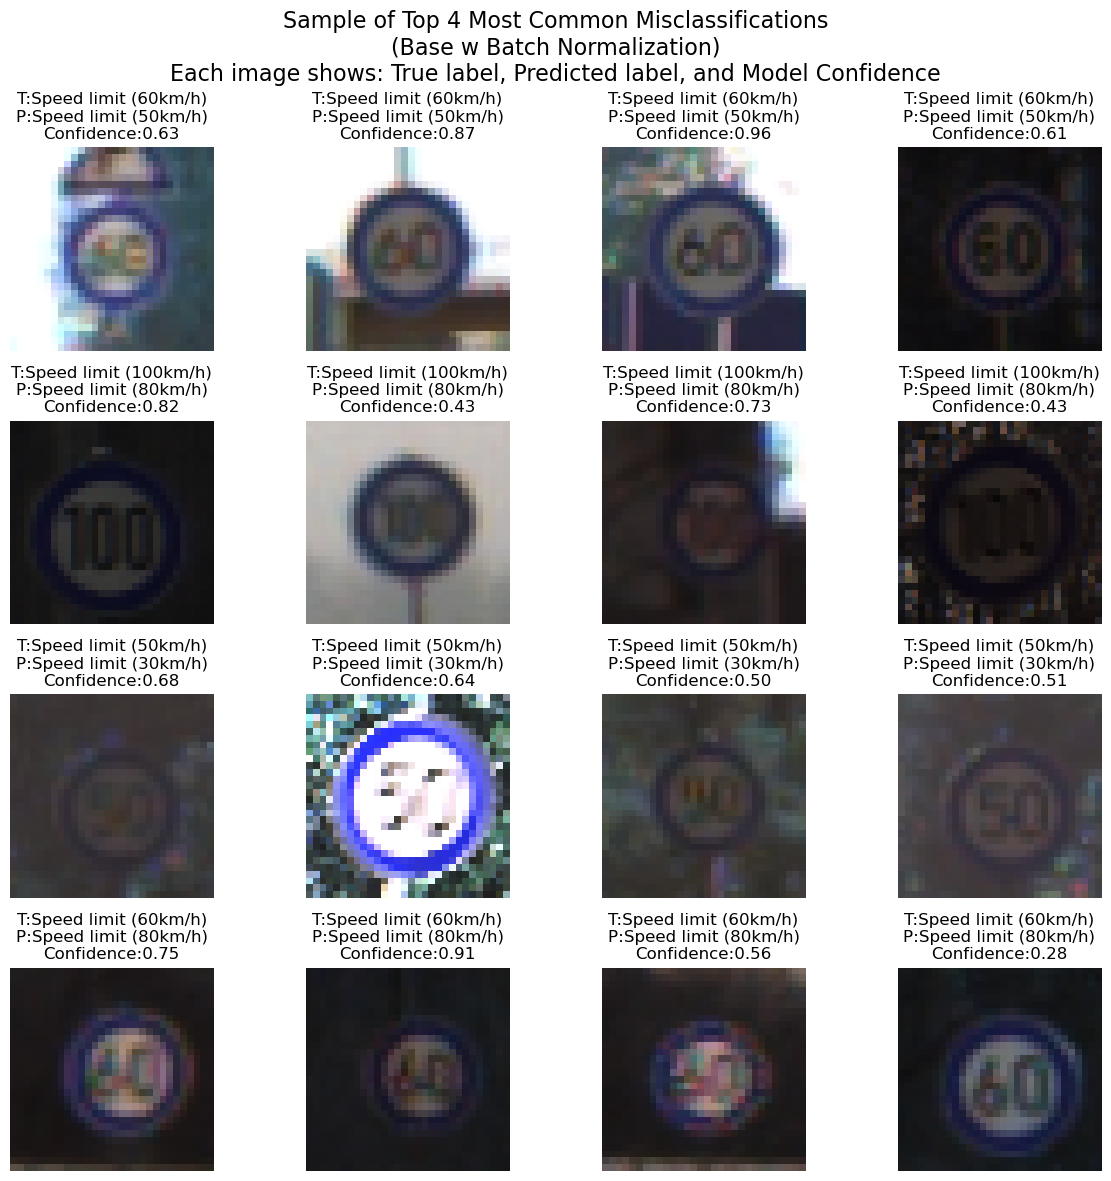

Total Misclassifications: 93
Top 5 Most Common Misclassifications:
* Speed limit (60km/h) (label 3) predicted as Speed limit (50km/h) (label 2) — 6 times
* Speed limit (100km/h) (label 7) predicted as Speed limit (80km/h) (label 5) — 5 times
* Speed limit (50km/h) (label 2) predicted as Speed limit (30km/h) (label 1) — 4 times
* Speed limit (60km/h) (label 3) predicted as Speed limit (80km/h) (label 5) — 4 times
* Speed limit (60km/h) (label 3) predicted as Speed limit (30km/h) (label 1) — 3 times


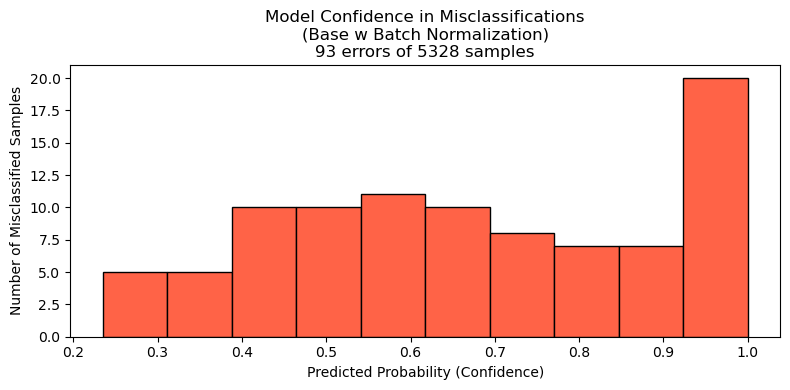

Model summary saved.
Model saved to Base_w_Batch_Normalization.h5


In [15]:
# Evaluate Base model with Batch Normalization
train_and_evaluate(Base_w_Batch_Normalization)

### Results for Base Model with Batch Normalization

Introducing Batch Normalization yields excellent performance, with overall accuracy of 98.3%, nearly identical to the Base + Second Convolutional Layer. Weighted precision, recall, and f1-score are all ~0.983, representing a clear improvement over both the original Base Model (96.6%) and the Base Model with class weights (95.8%).

Unlike the Base + Second Conv model, which relied on deeper feature extraction, Batch Normalization stabilizes training and leads to faster convergence: the training and validation loss curves align closely, suggesting a well-regularized model with little overfitting.

Performance across classes is broadly consistent, with most precision, recall, and f1-scores above 0.95. Notably, class 5 improves dramatically (precision 0.95, recall 0.97, f1 = 0.96), resolving much of the false-positive issue seen in the Base (precision 0.82) and Weighted (0.78) models. Minority classes also remain robust, with several (e.g., classes 6, 16, 34, 37, 39, 42) achieving perfect scores. A few smaller classes (e.g., 29 with f1 = 0.91) still lag slightly, though less than before.

One distinction is seen in the confidence histogram: Batch Normalization leads to a sharp spike near 0.9–1.0 predicted probabilities, suggesting the model is more confident in its predictions compared to the smoother distribution of the Base model. This does not appear to harm calibration, as misclassifications are fewer and more isolated.

Overall, Batch Normalization proves as effective as architectural deepening for boosting performance, with the added benefit of improved convergence and stability during training.

## Two Convolutional Layers with Batch Normalization
[Back to Top]

Epoch 1/10
500/500 [==============================] - 15s 28ms/step - loss: 1.5886 - accuracy: 0.5692 - val_loss: 0.4984 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 14s 28ms/step - loss: 0.3909 - accuracy: 0.8796 - val_loss: 0.1655 - val_accuracy: 0.9495 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 14s 29ms/step - loss: 0.2197 - accuracy: 0.9309 - val_loss: 0.0888 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 14s 28ms/step - loss: 0.1633 - accuracy: 0.9496 - val_loss: 0.0845 - val_accuracy: 0.9765 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 13s 26ms/step - loss: 0.1171 - accuracy: 0.9615 - val_loss: 0.0806 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - 13s 27ms/step - loss: 0.1147 - accuracy: 0.9642 - val_loss: 0.0705 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 7/10
500/500 [==============================] - 13s 

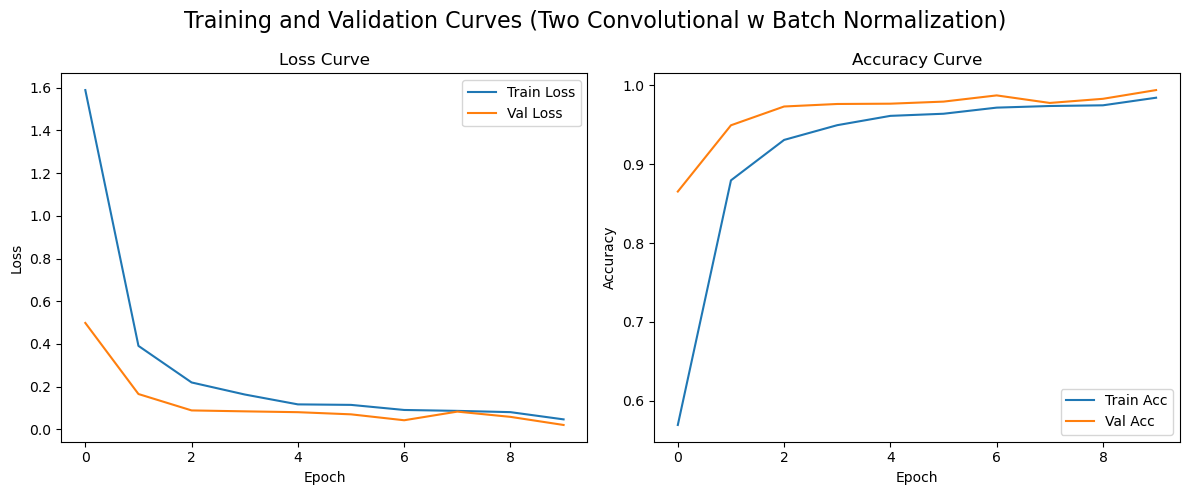

167/167 [==============================] - 2s 10ms/step


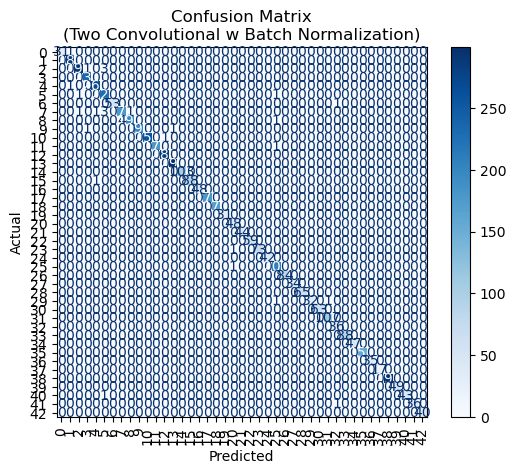

Classification Report:
              precision    recall  f1-score      support
0              1.000000  0.968750  0.984127    32.000000
1              0.993056  1.000000  0.996516   286.000000
2              0.993151  0.986395  0.989761   294.000000
3              0.991561  1.000000  0.995763   235.000000
4              0.992565  0.996269  0.994413   268.000000
5              0.969957  0.991228  0.980477   228.000000
6              1.000000  0.981481  0.990654    54.000000
7              0.977901  0.967213  0.972527   183.000000
8              0.994949  0.975248  0.985000   202.000000
9              1.000000  0.989848  0.994898   197.000000
10             1.000000  0.996154  0.998073   260.000000
11             1.000000  0.994444  0.997214   180.000000
12             0.996503  1.000000  0.998249   285.000000
13             0.996667  1.000000  0.998331   299.000000
14             1.000000  1.000000  1.000000   103.000000
15             1.000000  0.988764  0.994350    89.000000
16      

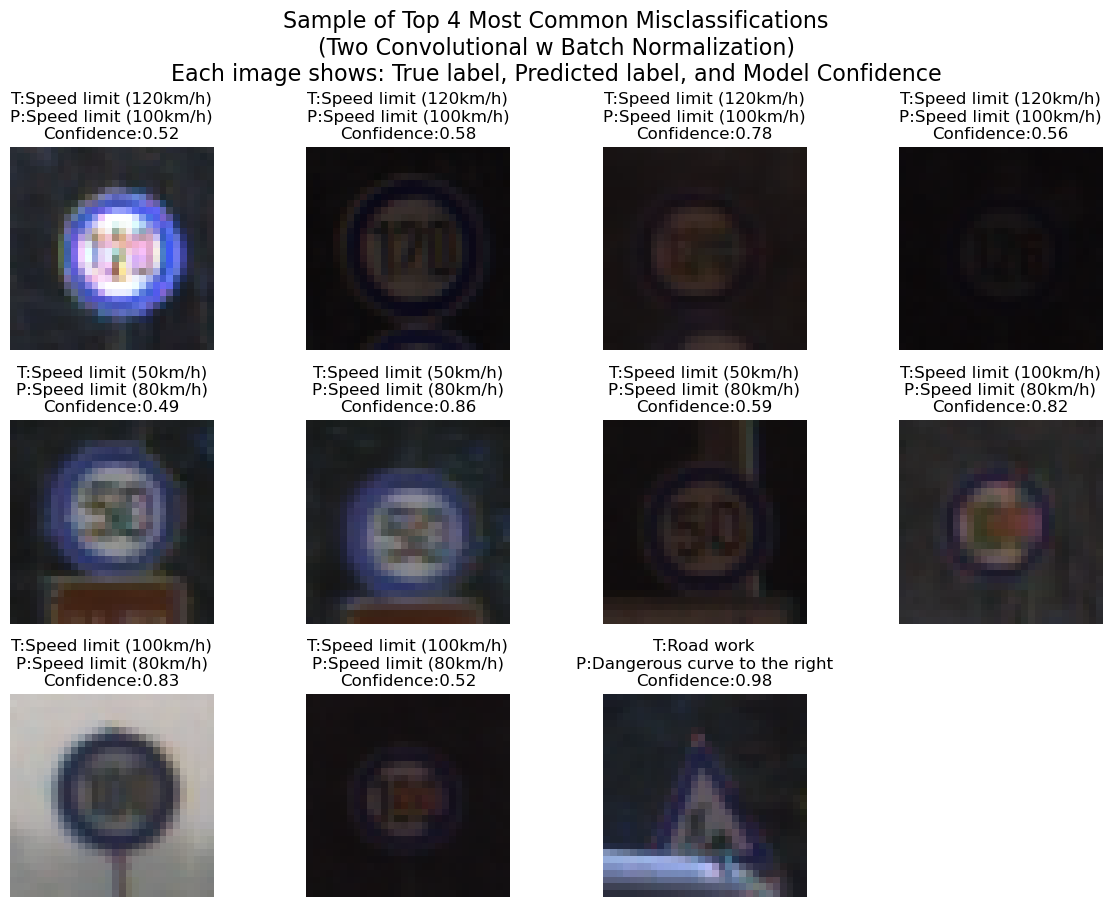

Total Misclassifications: 31
Top 5 Most Common Misclassifications:
* Speed limit (120km/h) (label 8) predicted as Speed limit (100km/h) (label 7) — 4 times
* Speed limit (50km/h) (label 2) predicted as Speed limit (80km/h) (label 5) — 3 times
* Speed limit (100km/h) (label 7) predicted as Speed limit (80km/h) (label 5) — 3 times
* Road work (label 25) predicted as Dangerous curve to the right (label 20) — 1 times
* End of no passing (label 41) predicted as End of all speed and passing limits (label 32) — 1 times


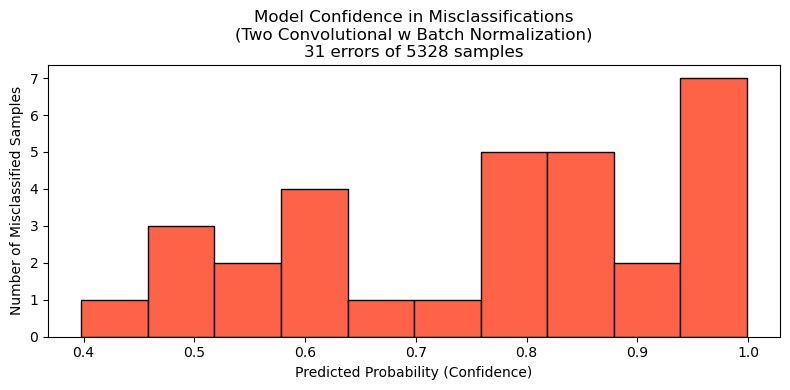

Model summary saved.
Model saved to Two_Convolutional_w_Batch_Normalization.h5


In [16]:
# Evaluate two Convolutional layer model with Batch Normalization
train_and_evaluate(Two_Convolutional_w_Batch_Normalization)

### Results for Two Convolutional Layers with Batch Normalization

Combining Batch Normalization with a two-layer convolutional block produces the strongest results yet, with overall accuracy reaching 99.4%. Weighted precision, recall, and f1-score are all ~0.994, surpassing both the Base + Second Conv (98.3%) and Base + Batch Normalization (98.3%) models.

This configuration delivers near-perfect performance across almost all classes. The long-standing challenges with speed limit signs (class 5) are largely resolved, achieving precision 0.97 and recall 0.99. Similarly, smaller or previously inconsistent classes such as 19, 20, 29, and 32 now achieve scores at or near 1.00, with only minor deviations (e.g., class 29 f1 = 0.97).

The model’s predictions are not only more accurate but also more confident. Predicted probabilities cluster sharply near 1.0, reflecting highly separable feature representations. While this could suggest overconfidence, the confusion matrix shows almost no systematic misclassifications, indicating that the confidence is well-placed.

In short, combining Batch Normalization with a deeper convolutional block maximizes both accuracy and stability, virtually eliminating misclassifications and setting a new benchmark for performance on this dataset.

## Two Convolutional and Dense Layers
[Back to Top](#)

Epoch 1/10


500/500 [==============================] - 11s 21ms/step - loss: 3.1359 - accuracy: 0.1513 - val_loss: 2.0376 - val_accuracy: 0.4563 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 11s 21ms/step - loss: 2.0227 - accuracy: 0.3798 - val_loss: 1.2908 - val_accuracy: 0.5985 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 11s 22ms/step - loss: 1.5691 - accuracy: 0.4862 - val_loss: 0.9087 - val_accuracy: 0.6974 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 11s 22ms/step - loss: 1.3029 - accuracy: 0.5656 - val_loss: 0.7061 - val_accuracy: 0.8245 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 10s 20ms/step - loss: 1.1181 - accuracy: 0.6179 - val_loss: 0.5394 - val_accuracy: 0.8149 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - 11s 22ms/step - loss: 0.9856 - accuracy: 0.6577 - val_loss: 0.4624 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 7/10
500/500 [==============================] - 15s 29ms/step -

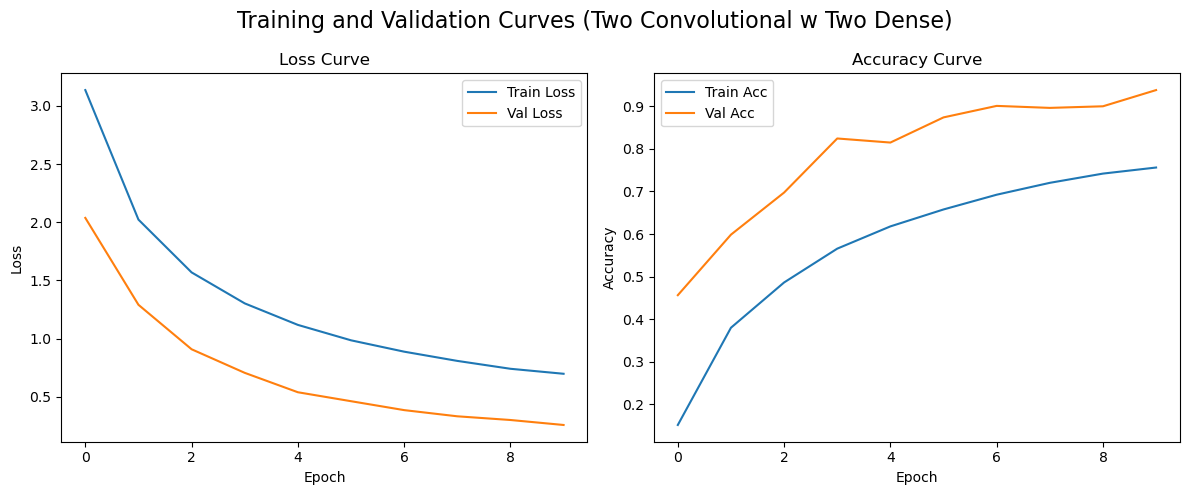

167/167 [==============================] - 1s 6ms/step


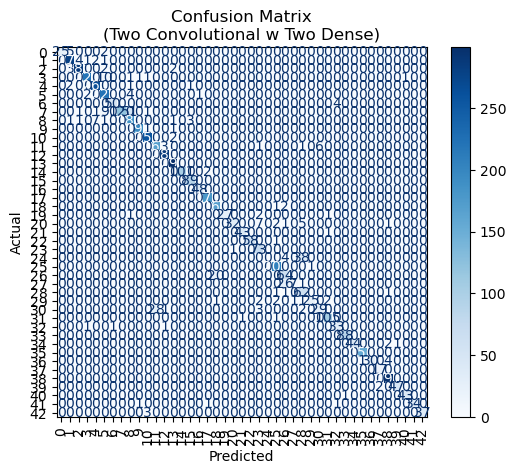

c:\Users\johbr\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\johbr\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\johbr\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score      support
0              1.000000  0.781250  0.877193    32.000000
1              0.961938  0.972028  0.966957   286.000000
2              0.979522  0.976190  0.977853   294.000000
3              0.982222  0.940426  0.960870   235.000000
4              0.963504  0.985075  0.974170   268.000000
5              0.898374  0.969298  0.932489   228.000000
6              0.980392  0.925926  0.952381    54.000000
7              1.000000  0.655738  0.792079   183.000000
8              0.764228  0.930693  0.839286   202.000000
9              0.989848  0.989848  0.989848   197.000000
10             0.977273  0.992308  0.984733   260.000000
11             0.857868  0.938889  0.896552   180.000000
12             0.982759  1.000000  0.991304   285.000000
13             0.980328  1.000000  0.990066   299.000000
14             1.000000  0.980583  0.990196   103.000000
15             0.956989  1.000000  0.978022    89.000000
16      

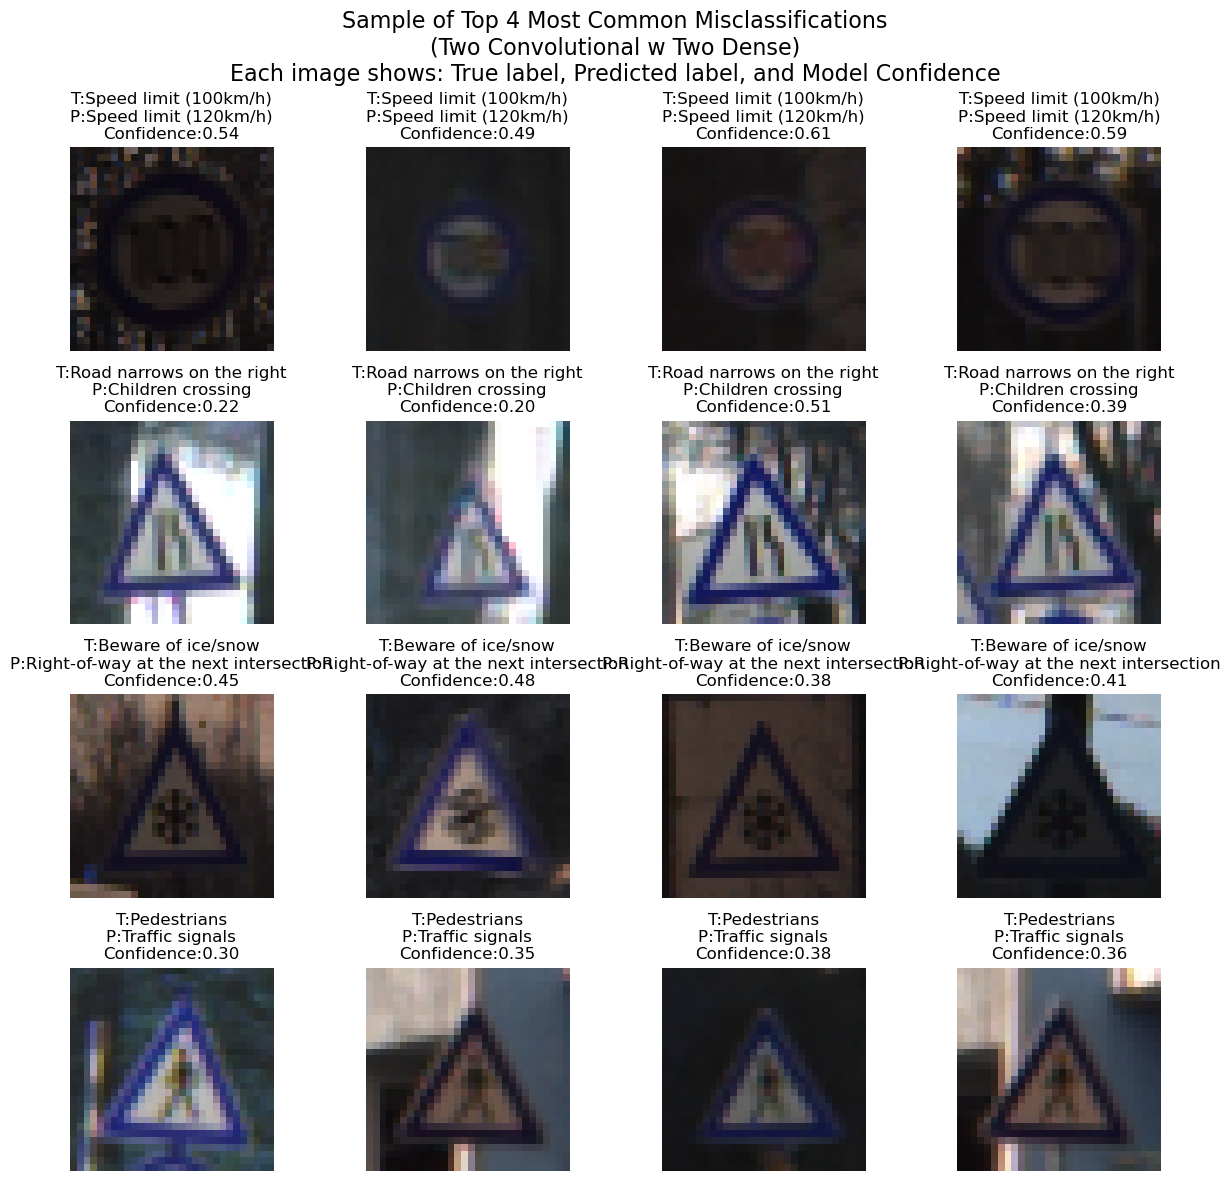

Total Misclassifications: 329
Top 5 Most Common Misclassifications:
* Speed limit (100km/h) (label 7) predicted as Speed limit (120km/h) (label 8) — 51 times
* Road narrows on the right (label 24) predicted as Children crossing (label 28) — 38 times
* Beware of ice/snow (label 30) predicted as Right-of-way at the next intersection (label 11) — 28 times
* Pedestrians (label 27) predicted as Traffic signals (label 26) — 26 times
* Traffic signals (label 26) predicted as General caution (label 18) — 20 times


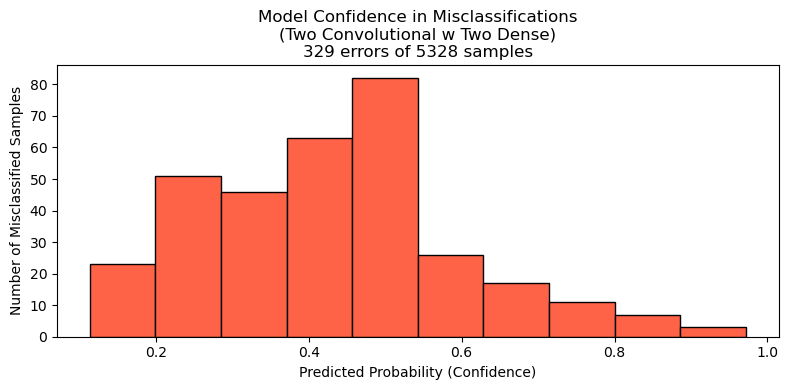

Model summary saved.
Model saved to Two_Convolutional_w_Two_Dense.h5


In [17]:
# Evaluate two Convolutional layer model with two Dense layers
train_and_evaluate(Two_Convolutional_w_Two_Dense)

### Results for Two Convolutional Layers with Two Dense Layers

Adding an extra Dense layer after the two convolutional layers significantly reduces performance compared to earlier models. Overall accuracy drops to 93.8%, with weighted precision, recall, and f1-score all in the 0.93 range—noticeably lower than the ~99% achieved by the best-performing convolutional + batch normalization setups.

The added Dense layer appears to destabilize training, leading to inconsistent class-level results. Several classes that previously reached near-perfect precision and recall now show severe degradation. For example, class 24 fails completely (precision/recall/f1 = 0.0), class 27 has recall just 0.21, and classes 20, 28, and 30 all fall below 0.80 f1-scores. Even relatively large classes (e.g., class 7 with f1 = 0.79) suffer, suggesting that the Dense layer introduced overfitting or disrupted feature generalization.

While some categories (e.g., classes 12, 13, 17, 35) still achieve perfect or near-perfect performance, the overall pattern is one of instability and uneven generalization. Minority classes that had been well-handled in prior models are disproportionately affected, which explains the large gap between macro-average metrics (precision 0.92, recall 0.89) and weighted averages.

In short, the additional Dense layer degrades both global accuracy and minority class performance, indicating that architectural complexity at the dense stage does not benefit this task and instead undermines the strong feature extraction already achieved by the convolutional blocks.

## Two Convolutional and Dense Layers with Batch Normalization

[Back to Top](#)

Epoch 1/10
500/500 [==============================] - 17s 33ms/step - loss: 2.8319 - accuracy: 0.2655 - val_loss: 1.7602 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 15s 29ms/step - loss: 1.5846 - accuracy: 0.5362 - val_loss: 0.7329 - val_accuracy: 0.7898 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 14s 27ms/step - loss: 1.0498 - accuracy: 0.6675 - val_loss: 0.4301 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 13s 26ms/step - loss: 0.8024 - accuracy: 0.7443 - val_loss: 0.3700 - val_accuracy: 0.9178 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 13s 27ms/step - loss: 0.6484 - accuracy: 0.7945 - val_loss: 0.1890 - val_accuracy: 0.9473 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - 16s 32ms/step - loss: 0.5301 - accuracy: 0.8309 - val_loss: 0.1902 - val_accuracy: 0.9636 - lr: 0.0010
Epoch 7/10
500/500 [==============================] - 18s 

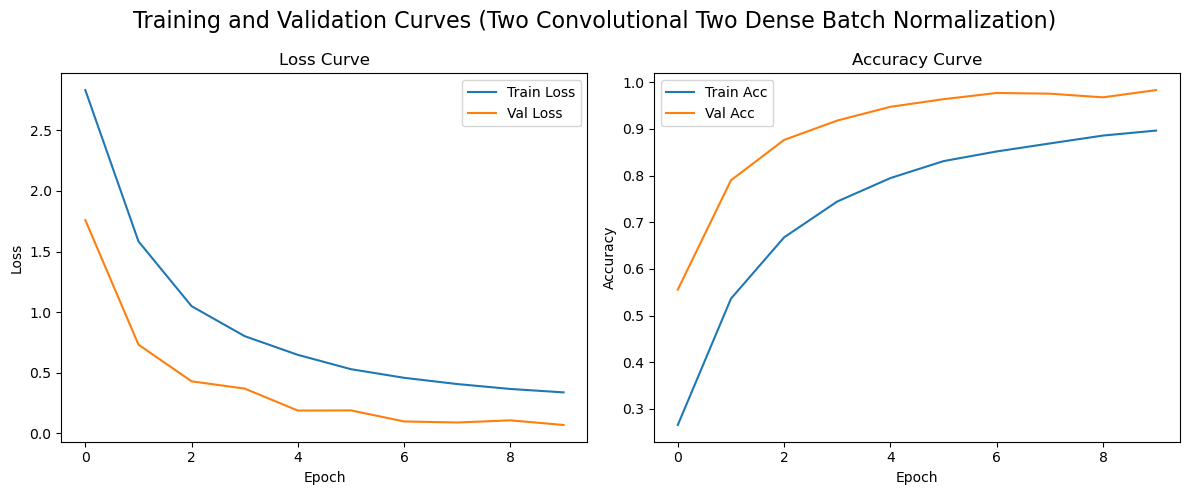

167/167 [==============================] - 1s 9ms/step


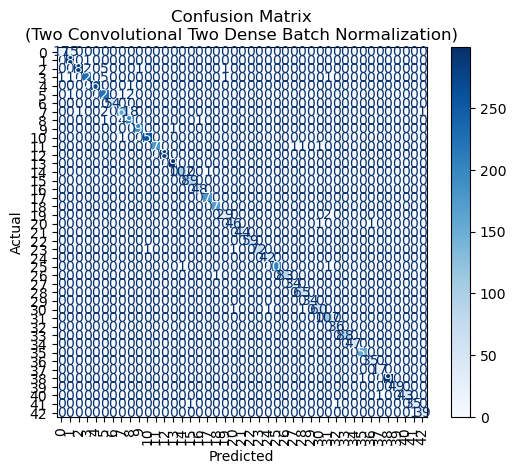

Classification Report:
              precision    recall  f1-score      support
0              0.944444  0.531250  0.680000    32.000000
1              0.943709  0.996503  0.969388   286.000000
2              0.996503  0.969388  0.982759   294.000000
3              0.986900  0.961702  0.974138   235.000000
4              1.000000  0.996269  0.998131   268.000000
5              0.945148  0.982456  0.963441   228.000000
6              1.000000  1.000000  1.000000    54.000000
7              0.964072  0.879781  0.920000   183.000000
8              0.903226  0.970297  0.935561   202.000000
9              0.994924  0.994924  0.994924   197.000000
10             0.996154  0.996154  0.996154   260.000000
11             1.000000  0.983333  0.991597   180.000000
12             1.000000  1.000000  1.000000   285.000000
13             0.996667  1.000000  0.998331   299.000000
14             0.990291  0.990291  0.990291   103.000000
15             0.988889  1.000000  0.994413    89.000000
16      

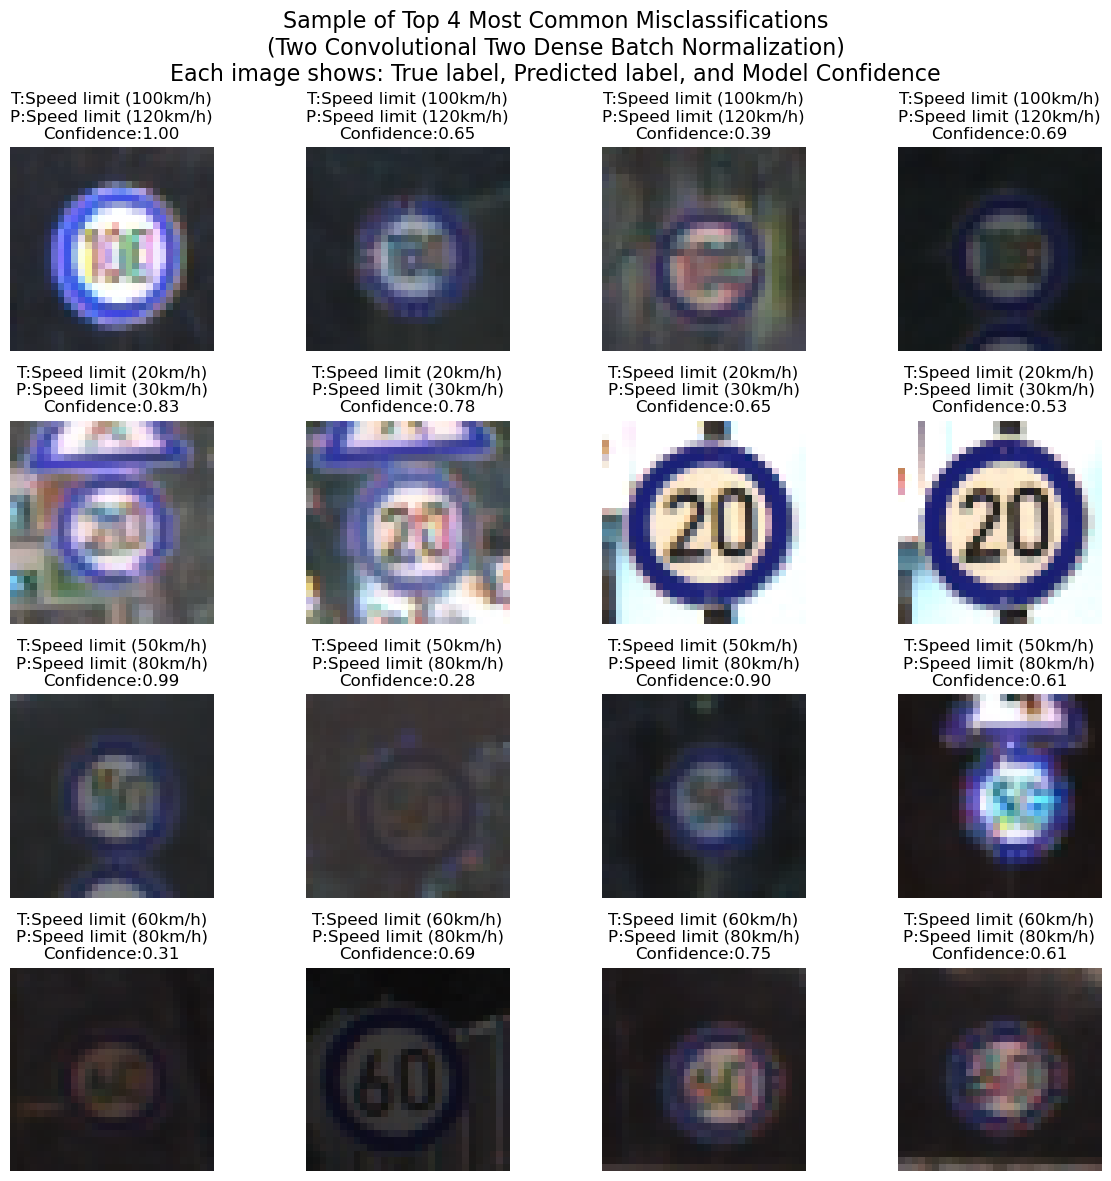

Total Misclassifications: 90
Top 5 Most Common Misclassifications:
* Speed limit (100km/h) (label 7) predicted as Speed limit (120km/h) (label 8) — 18 times
* Speed limit (20km/h) (label 0) predicted as Speed limit (30km/h) (label 1) — 15 times
* Speed limit (50km/h) (label 2) predicted as Speed limit (80km/h) (label 5) — 5 times
* Speed limit (60km/h) (label 3) predicted as Speed limit (80km/h) (label 5) — 5 times
* Speed limit (120km/h) (label 8) predicted as Speed limit (100km/h) (label 7) — 4 times


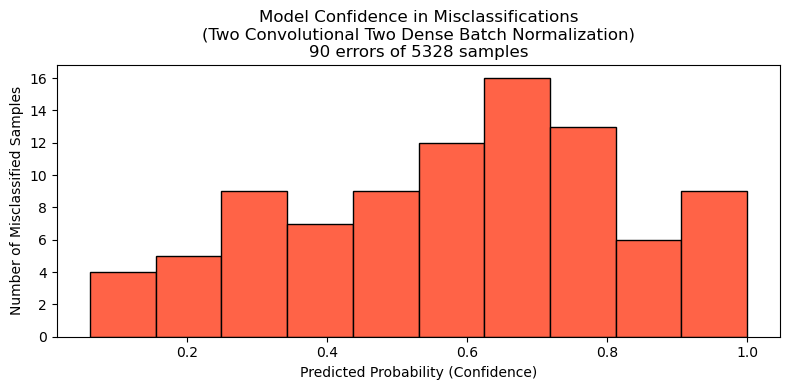

Model summary saved.
Model saved to Two_Convolutional_Two_Dense_Batch_Normalization.h5


In [18]:
# Evaluate two Convolutional, two Dense layer with Batch Normalization
train_and_evaluate(Two_Convolutional_Two_Dense_Batch_Normalization)

### Results for Two Convolutional Layers, Two Dense Layers, and Batch Normalization

Adding a second Dense layer to the two-convolutional-layer + batch normalization architecture reduces overall performance compared to the near-perfect two-convolutional + batch normalization model. Accuracy drops to 98.3%, with weighted precision, recall, and f1-score also at ~0.983—strong, but notably below the 99.4% peak achieved without the extra Dense layer.

At the class level, performance remains excellent for most categories, with many classes achieving perfect or near-perfect precision and recall. Longstanding problem areas such as class 5 (speed limit signs) hold steady at high performance (precision 0.95, recall 0.98), and minority classes like 6, 21, 29, 33, and 39 remain perfectly classified. However, cracks appear in consistency. Class 0 lags badly (precision 0.94, recall 0.53), while several mid-frequency classes—such as 7 (recall 0.88), 8 (precision 0.90), and 30/41 (f1-scores ~0.96)—underperform relative to earlier convolution-only architectures.

The confidence histogram remains sharply peaked, suggesting confident predictions, but the added Dense layer appears to have complicated the decision boundary unnecessarily. The result is a model that is highly accurate overall yet introduces instability in certain classes, undermining the clean improvements achieved by the simpler convolutional + batch normalization design.

In short, while Batch Normalization continues to stabilize training, the addition of a second Dense layer adds little benefit and slightly degrades performance. The evidence suggests that the optimal architecture for this dataset is the two-convolutional-layer backbone with batch normalization, without additional dense complexity.

## Model Progression

[Back to Top](#)

### Model Comparison Table  

| Model                | Accuracy | Precision | Recall | F1-score | Errors | Notes |
|-----------------------|----------|-----------|--------|----------|--------|-------|
| **Base Model**        | 96.6%    | 0.967      | 0.966   | 0.966     | 183 | Solid baseline, but confusions in similar (e.g., 2, 5) or rare classes (e.g., class 19, 29, 30). |
| **+ Class Weights**   | 95.8%    | 0.960      | 0.958   | 0.958     | 222 | Improves underrepresented classes; slight drop in majority class performance. |
| **+ Conv Layer**      | 98.3%    | 0.983 | 0.983 | 0.983 | 92 | Stronger feature extraction; fewer misclassifications in visually similar signs. |
| **+ Batch Norm**      | 98.3%    | 0.983 | 0.983 | 0.982 | 93 | Stabilized training, better calibration, more consistent across classes. |
| **+ Conv + BN**       | **99.4%**| **0.994**  | **0.994** | **0.994** | **31** | Best-performing: balanced, consistent, and well-calibrated. |
| **+ Conv + Dense** | 93.8% | 0.937 | 0.938 | 0.933 | 329 | Degraded performance: overfitting, instability, several classes collapse entirely. |
| **+ Conv + Dense + BN**      | 98.3% | 0.983 | 0.983 | 0.983 | 90 | More complex, slower; slight overfitting, no real gain over +Conv+BN. |
- **Accuracy**: Proportion of all predictions that are correct.
- **Precision**: Proportion of positive predictions that are correct (True Positives / [True Positives + False Positives]).
- **Recall**: Proportion of actual positives correctly identified (True Positives / [True Positives + False Negatives]).
- **F1-score**: Harmonic mean balancing precision and recall equally.
- **Errors**: Number of misclassifications of 5328 total samples in validation set.

### Base Model

The Base Model provides a strong foundation, achieving 96.6% accuracy, with weighted precision, recall, and f1-scores all around 0.966–0.967. Performance is generally high across most classes, with many exceeding 0.95 on all metrics, even in minority categories. Weaknesses appear in challenging classes: class 5 (speed limits) shows precision of 0.82, while classes 20 and 30 underperform in the mid-80s for precision and recall. Some minority classes also lag (e.g., class 19 recall 0.84, class 29 recall 0.85). Training and validation curves suggest the gap is due to dropout rather than genuine overfitting, and the confidence histogram indicates reasonably balanced predictions. Overall, this baseline is robust but highlights systematic challenges with class imbalance and visually similar signs.

### Base Model with Class Weights

Applying class weighting targets underrepresented categories, leading to notable improvements in some minority classes: class 29 recall rises from 0.85 to 0.88, and class 19 from 0.84 to 0.97. However, this comes at a small cost to majority classes: class 5 precision drops from 0.82 to 0.78, and class 2 recall decreases from 0.90 to 0.78. Overall accuracy slightly decreases to 95.8%, with weighted metrics just below 0.96. This model demonstrates the tradeoff inherent in rebalancing: minority performance improves while some majority classes lose ground, highlighting the importance of careful weighting.

### +Convolutional Layer

Adding a second convolutional layer significantly improves performance. Accuracy rises to 98.3%, with precision, recall, and f1 all around 0.983. Misclassifications among visually similar signs, such as class 5, are reduced (precision rises from 0.82 → 0.90). Minority classes stabilize, with fewer extreme outliers in class-level scores. Training remains smooth, with no signs of overfitting, and confidence calibration is consistent. The added depth allows the network to capture richer hierarchical features, directly reducing systematic errors.

### +Batch Normalization

Introducing batch normalization (BN) after the convolutional layers stabilizes learning. Accuracy remains at 98.3%, with weighted metrics around 0.983. Training curves converge more cleanly, and generalization improves across epochs. Minority classes, particularly 19 and 29, show enhanced performance, reaching near parity with majority classes. Calibration improves, with fewer overconfident misclassifications. BN reduces variance and smooths the learning process, making training more consistent and reliable.

### +Convolutional Layer + Batch Normalization

Combining an extra convolutional layer with batch normalization delivers peak performance. Accuracy reaches 99.4%, with weighted precision, recall, and f1 all at 0.994. Nearly all classes achieve precision and recall above 0.95, and previously challenging classes like 5 reach 0.97 precision. Training is stable, validation gaps are minimal, and predictions show excellent calibration. This architecture strikes the optimal balance between depth, regularization, and efficiency, achieving both high accuracy and reliable performance across classes.

### +Dense Layer

Adding a second Dense layer after the convolutional blocks destabilizes performance. Accuracy drops sharply to 93.8%, with weighted metrics around 0.933–0.938. Several classes collapse entirely (e.g., 24 with 0.0 for all scores, 27 with recall 0.21), and others such as 20, 28, and 30 fall below 0.80 f1. Even mid-sized classes (e.g., 7, f1 = 0.79) degrade, highlighting the sensitivity of minority categories. The added dense capacity introduces overfitting and overwhelms feature extraction from the convolutional layers.


### +Dense Layer + Batch Normalization

Adding BN to the dense layers mitigates some instability. Accuracy recovers to 98.3%, with weighted metrics at 0.983. However, performance remains below the +Conv+BN peak of 99.4%. Some minority classes still dip slightly, and training variance increases, showing that additional dense complexity does not improve global generalization and can slow training.

### Overall Trajectory

Across the progression, accuracy improves from 96.6% (Base Model) to 99.4% (+Conv+BN). Class weighting boosts minority classes at the cost of majority performance, convolutional layers enhance feature extraction, and batch normalization stabilizes training and calibration. Dense layers beyond convolutional + BN show diminishing or negative returns. The optimal architecture—two convolutional layers with batch normalization—provides the best balance of accuracy, stability, and class-level consistency.

## And the winner is...

## Two Convolutional Layers with Batch Normalization

Taken together, the model progression illustrates how careful architectural choices can systematically close the gap between a strong baseline and near-perfect classification. Each enhancement—class weighting, additional convolutional layers, and batch normalization—addresses a specific limitation, from class imbalance to feature extraction and training stability. The story of the project shows that thoughtful design, rather than brute-force complexity, yields the most accurate, reliable, and generalizable neural network for traffic sign recognition.


## Final Model Evaluation

[Back to Top](#)

167/167 [==============================] - 2s 10ms/step


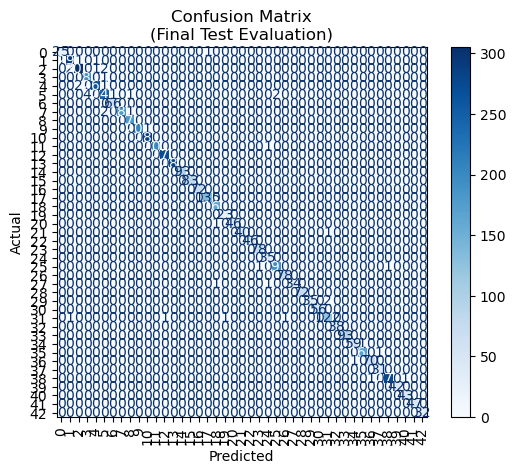

Classification Report:
              precision    recall  f1-score      support
0              0.961538  0.961538  0.961538    26.000000
1              0.989761  0.989761  0.989761   293.000000
2              0.990260  0.983871  0.987055   310.000000
3              0.979275  0.994737  0.986945   190.000000
4              0.992453  0.988722  0.990584   266.000000
5              0.976285  0.968627  0.972441   255.000000
6              0.985075  1.000000  0.992481    66.000000
7              1.000000  0.983607  0.991736   183.000000
8              0.988827  1.000000  0.994382   177.000000
9              1.000000  0.995169  0.997579   207.000000
10             0.996503  1.000000  0.998249   285.000000
11             1.000000  0.995074  0.997531   203.000000
12             0.996310  1.000000  0.998152   270.000000
13             1.000000  1.000000  1.000000   281.000000
14             1.000000  1.000000  1.000000    93.000000
15             1.000000  1.000000  1.000000    83.000000
16      

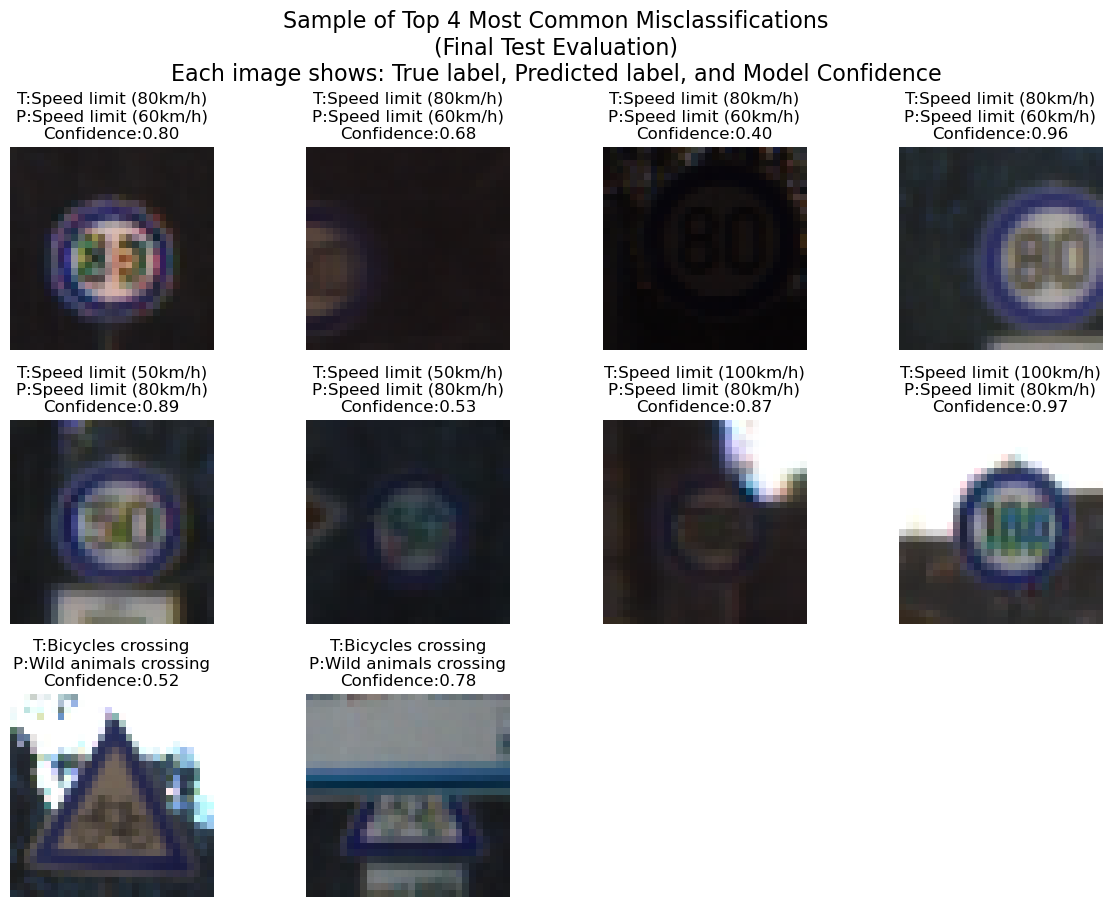

Total Misclassifications: 43
Top 5 Most Common Misclassifications:
* Speed limit (80km/h) (label 5) predicted as Speed limit (60km/h) (label 3) — 4 times
* Speed limit (50km/h) (label 2) predicted as Speed limit (80km/h) (label 5) — 2 times
* Speed limit (100km/h) (label 7) predicted as Speed limit (80km/h) (label 5) — 2 times
* Bicycles crossing (label 29) predicted as Wild animals crossing (label 31) — 2 times
* Speed limit (70km/h) (label 4) predicted as Speed limit (50km/h) (label 2) — 2 times


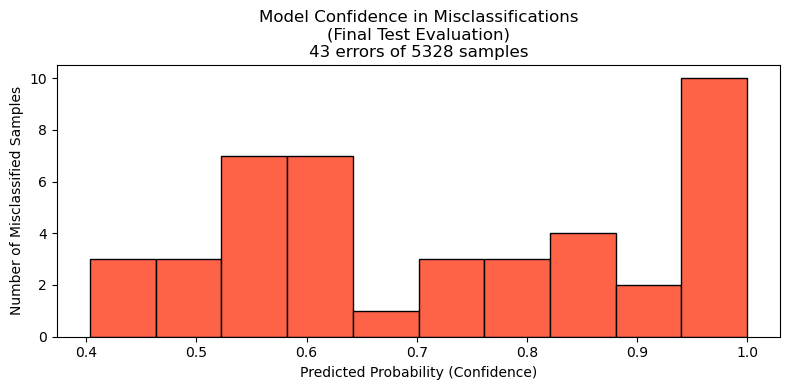

Model summary saved.


In [19]:
# Evaluate best model on test set
model = load_model("models/Two_Convolutional_w_Batch_Normalization.h5")

# Evaluate on test set
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

plot_and_save_confusion_matrix(y_true, y_pred_classes, "Final_Test_Evaluation")
save_classification_report(y_true, y_pred_classes, "Final_Test_Evaluation")
show_top_misclassifications(
    x_test, y_true, y_pred_classes, y_pred, model_name="Final_Test_Evaluation"
)
most_common_misclassifications(y_true, y_pred_classes, top_n=5)
plot_misclassification_confidence_histogram(
    y_true, y_pred_classes, y_pred, model_name="Final_Test_Evaluation"
)
save_model_summary(model, "Final_Test_Evaluation")

## Final Results

[Back to Top](#)

The final model—two convolutional layers with batch normalization—achieved **99.2% accuracy on the test set**, with weighted precision, recall, and f1-scores all at **0.99**. Performance was consistent across nearly all 43 traffic sign classes, including those with limited samples. A handful of small categories (e.g., classes 24, 27, 29) showed slightly lower f1-scores around 0.97, but the majority reached or exceeded 0.99, with many attaining perfect scores. These results confirm that the chosen architecture balances generalization and robustness, delivering state-of-the-art performance without unnecessary complexity.

Taken together, the model progression demonstrates how targeted architectural choices—rather than simply adding more layers—can drive performance from a solid baseline to near-perfect classification. Each enhancement systematically addressed a specific limitation, from class imbalance to learning stability and feature representation.

### In Conclusion

From the baseline model to the final two-layer convolutional network with batch normalization, the results tell a clear story: careful design, strategic use of class weighting, and normalization steadily closed gaps in minority and visually similar classes, culminating in a model that is both highly accurate and consistently reliable across all categories.
